# Investigate simulations with individual soil column per pft  

Inlcuding regridding

(c) Inne Vanderkelen - October 2023

## 1. Settings

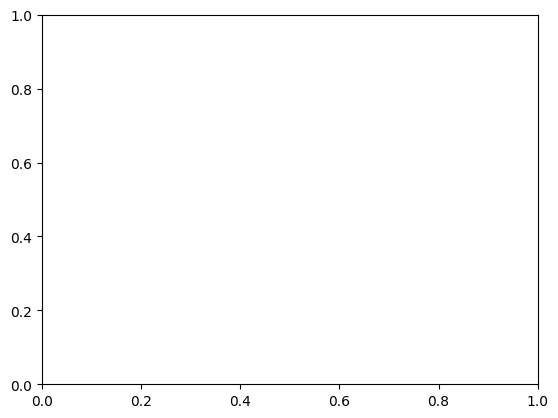

In [1]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 
import pandas as pd

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/scratch/snx3000/ivanderk/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

In [3]:
# case settings

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc", "TSA", ] #"SOILPSI", "FPSN","QHR","SMP","GSSHA","GSSUN"

# discard 2004 until 2008 as spin up years
start_year, end_year = 1990, 2014 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-31")

In [4]:
## settings for plotting
ds_ctl =  load_case_ctl(['H2OSOI'])

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)

regions_sand_clay = [6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

plotting_depth = 2 # m 8
figsize = (17,38)

In [5]:
# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]
pft_list_grassland = [0,13,14]

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [6]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

In [7]:
# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

In [8]:
# get masks for sandy and clay soils

# define tresholds for pct sand and pct clay
pct_sand_threshold_min = 50
pct_sand_threshold_max = 85
pct_clay_threshold = 40
da_sand_mask, da_clay_mask = get_texture_masks(pct_sand_threshold_max,pct_sand_threshold_min,  pct_clay_threshold, ds_input, levsoi_thickness)



In [9]:
# wilting point
# load precalculated wilting point datasets
da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

## Look at maps

## Look at saturation ratio for cropland

In [10]:
# RECALCULATED  saturation ratio
variable = 'H2OSOI'
pft_list = pft_list_crops

flag_calc_regionmeans = True

if flag_calc_regionmeans: 
    
    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, mask_regions)



processing pft: 15
processing region: 36 of 36
processing pft: 16
processing region: 36 of 36


In [11]:
# saturation ratio
variable = 'satfrac'
pft_list = pft_list_crops

flag_calc_regionmeans = False

if flag_calc_regionmeans: 

    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, mask_regions)


In [12]:
# saturation ratio
variable = 'watfc'
pft_list = pft_list_crops

flag_calc_regionmeans = False

if flag_calc_regionmeans: 

    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, mask_regions)


In [13]:
# CONTROL case root water uptake

variable = 'QROOTSINK'

flag_calc_regionmeans = False

if flag_calc_regionmeans: 

    for pft_int in pft_list_crops: 
        print('processing pft: '+str(pft_int))

        # calculate delta and relative delta of saturation ratio. 
        da_pft_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable)
        
        # calculate regional means. 
        ds_regions = calc_regionalmeans(da_pft_ctl, region_ids, mask_regions)

        ds_regions.to_netcdf(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.ctl.nc')
        
   

## Saturated fraction

### Relative change

In [10]:
pft_int = pft_list_crops[0]

variable = 'QROOTSINK'
da_ctl_region_qroot = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.ctl.nc')[variable]
da_ctl_region_qroot_seasmean = da_ctl_region_qroot.groupby('time.month').mean().squeeze()

flag_plot_rootuptake = True


In [11]:
# prepare for plotting 
flag_plot_rootuptake = False

variable = 'satfrac'
# open regions dataset
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.delta_change_rel.nc')[variable]

da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()



fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-3,3.25,0.25)
    ticks =np.arange(-3,3.5,0.5)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ Saturation ratio (%)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

### Absolute change

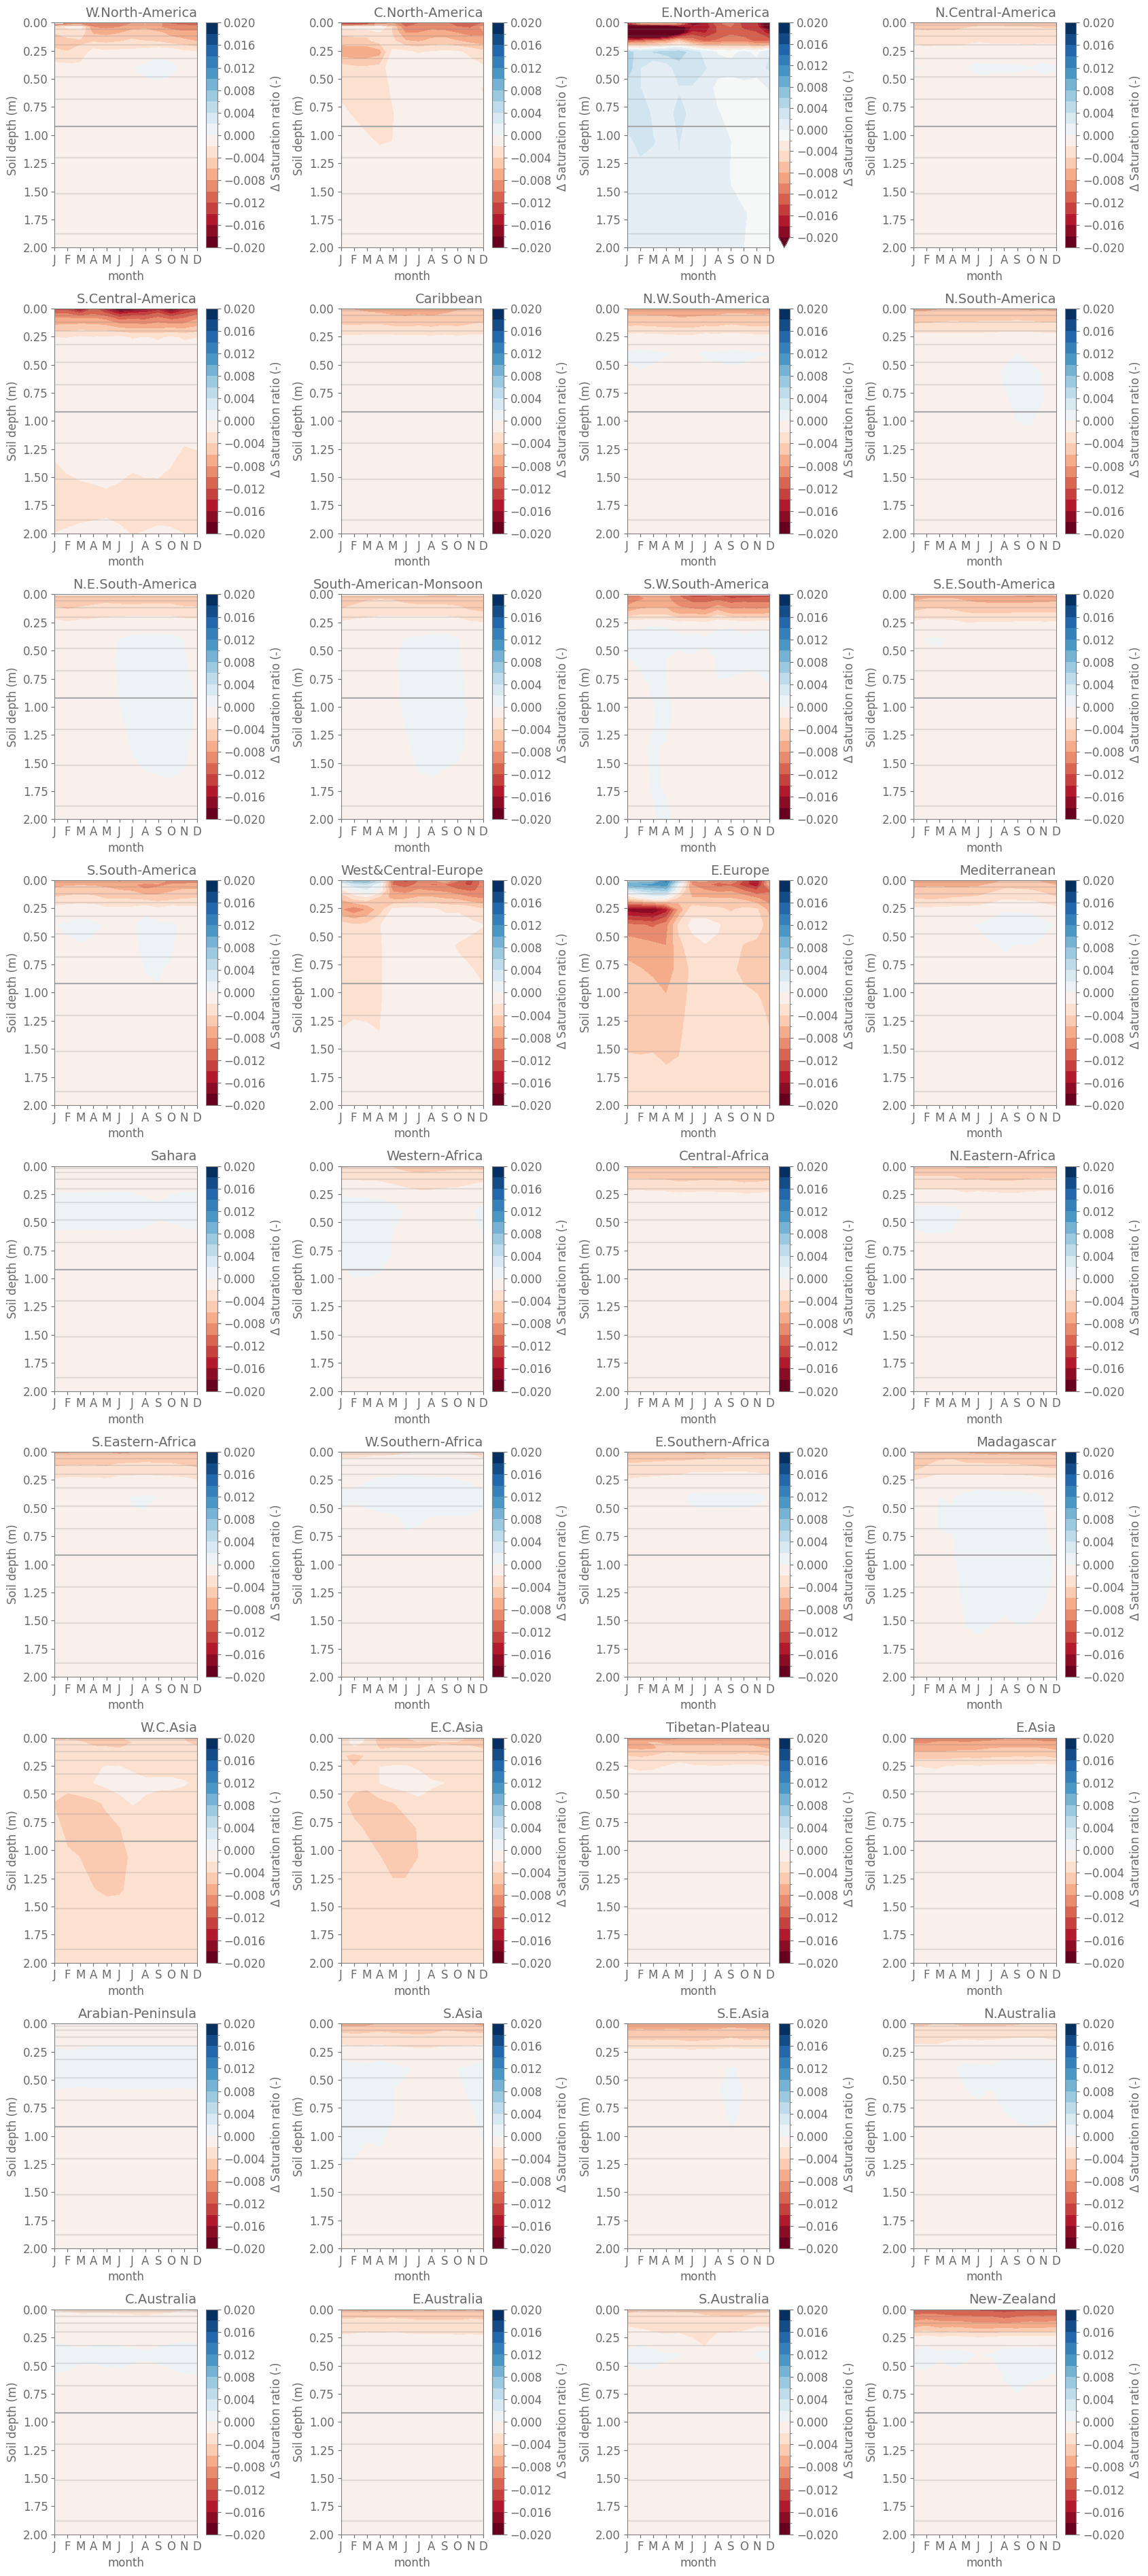

In [17]:
# prepare for plotting 
variable = 'satfrac'

# open regions dataset
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.delta_change.nc')[variable]

da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()



fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-0.02,0.022,0.002)
    ticks =np.arange(-0.02,0.024,0.004)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ Saturation ratio (-)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

## volumetric soil moisture

### relative change

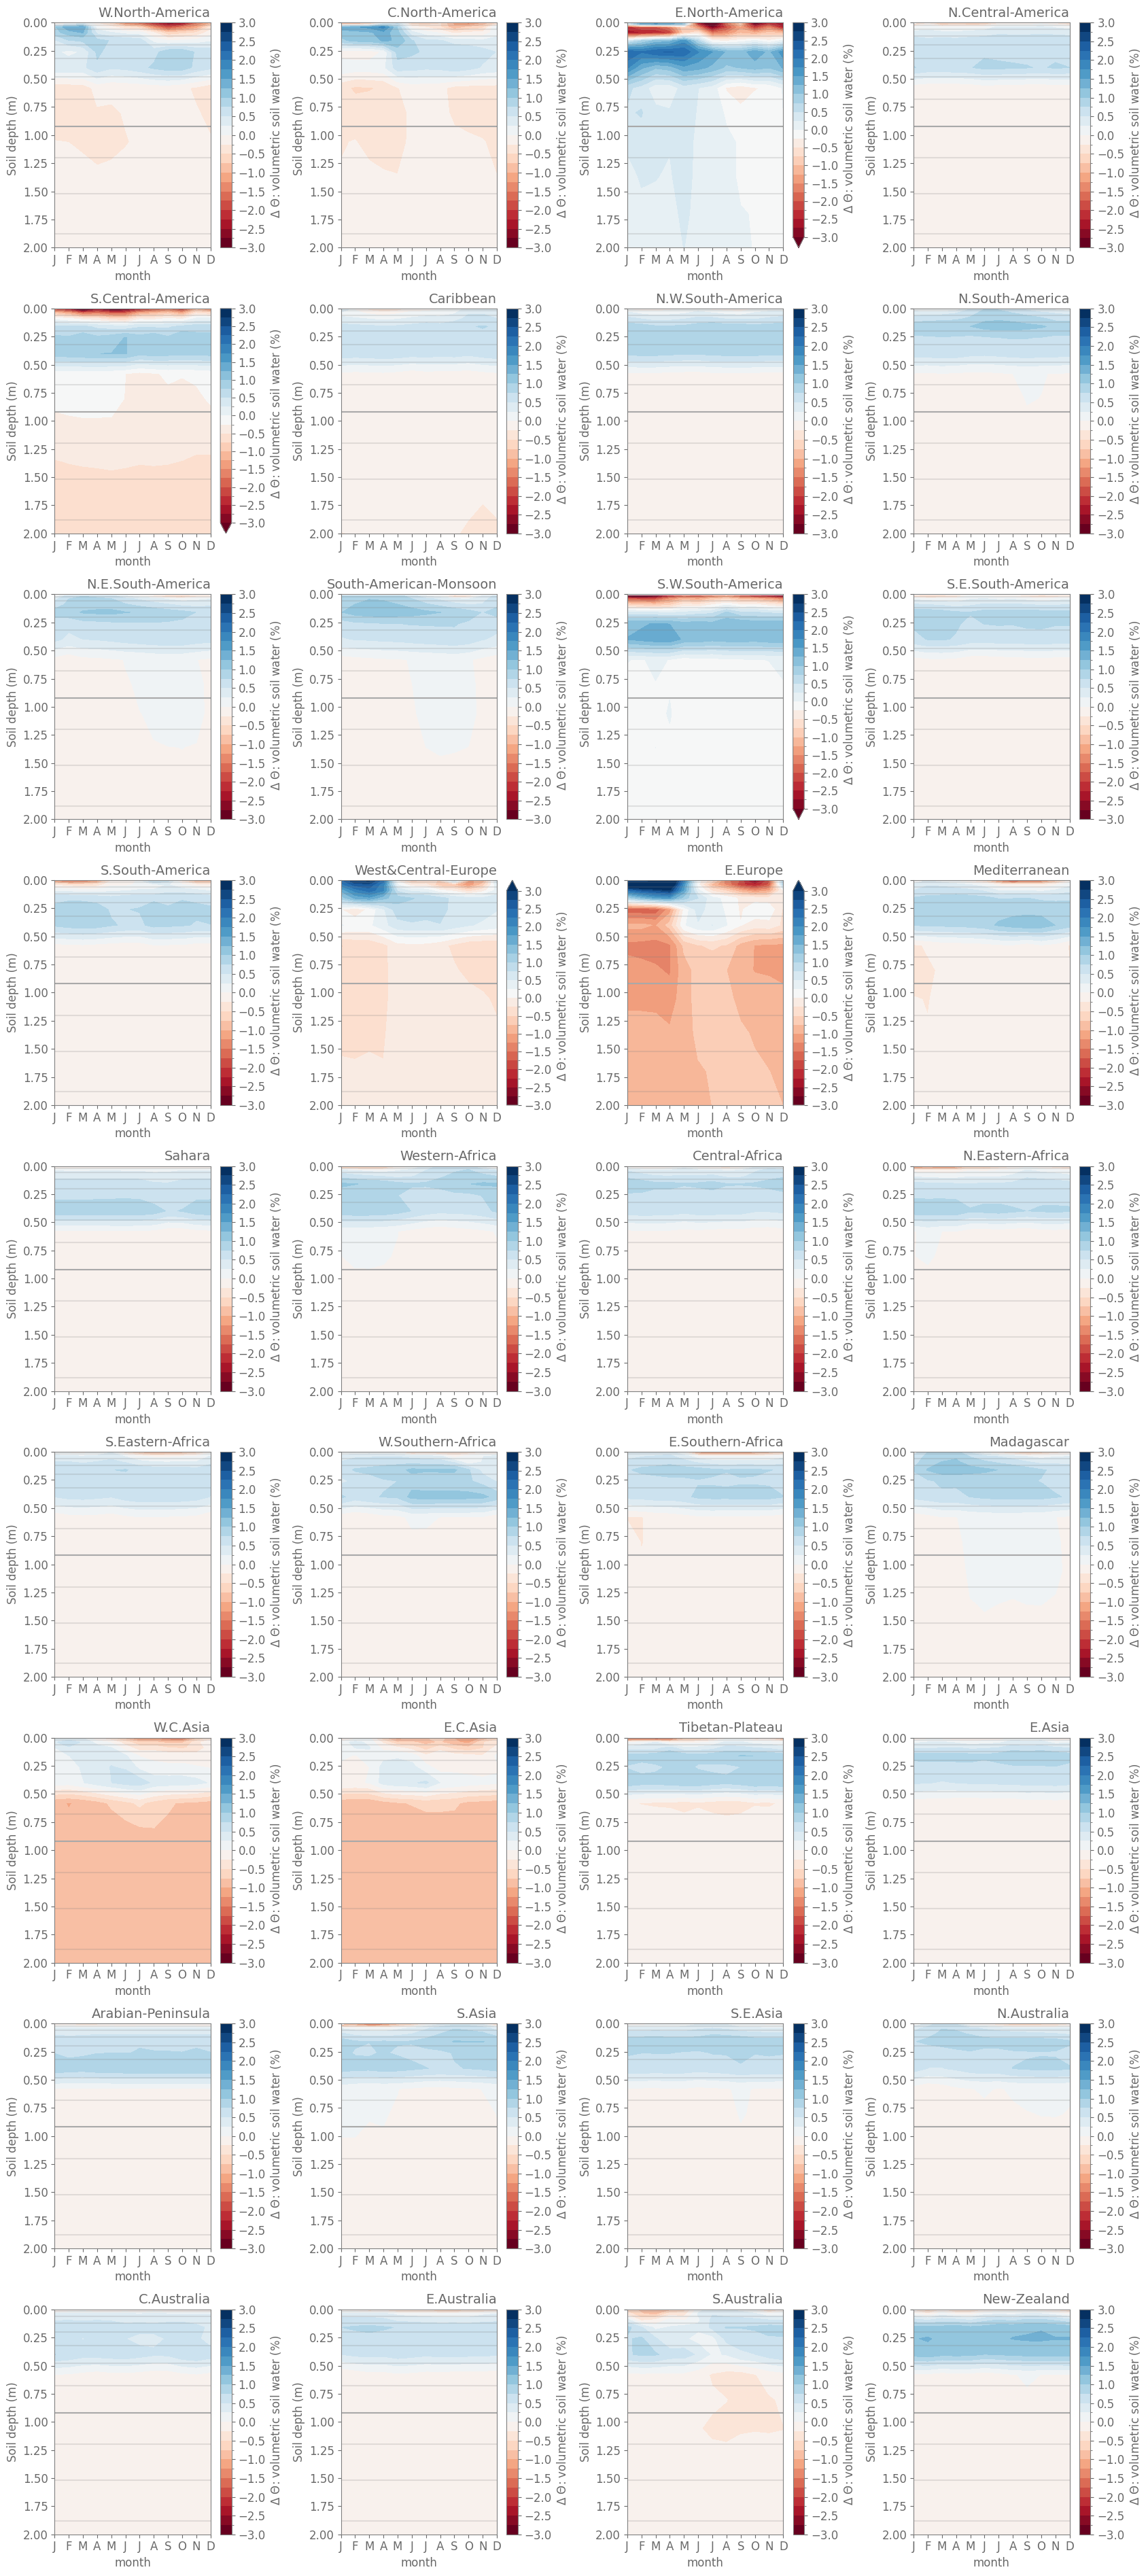

In [12]:
# prepare for plotting 
variable = 'H2OSOI'

# open regions dataset
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.delta_change_rel.nc')[variable]

da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()



fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-3,3.25,0.25)
    ticks =np.arange(-3,3.5,0.5)
    
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ $\Theta$: volumetric soil water (%)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

### absolute change

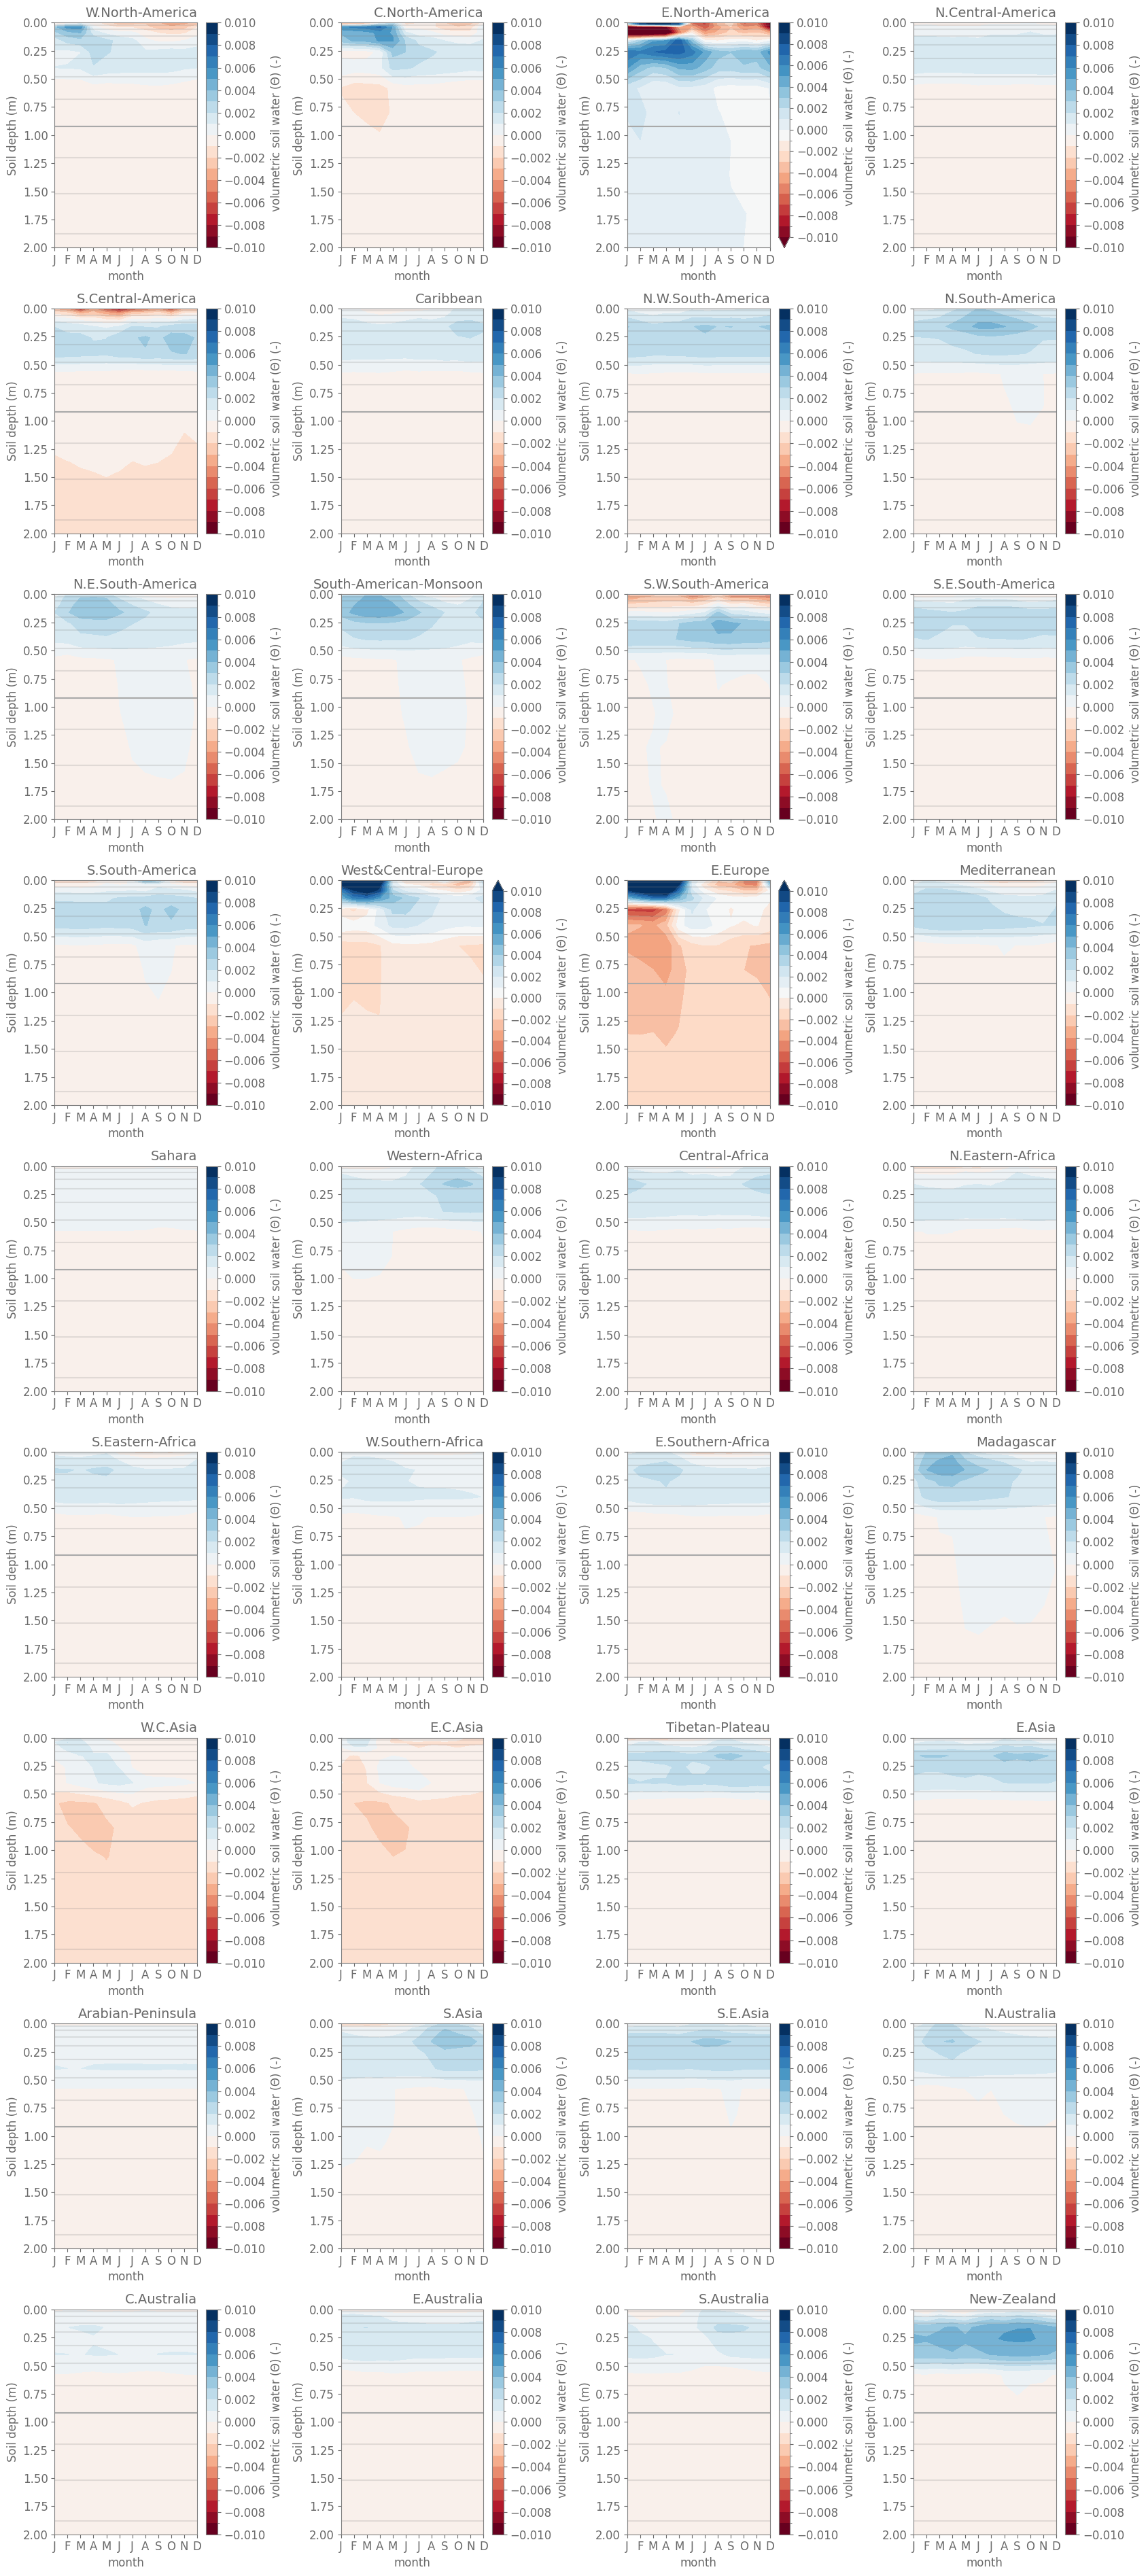

In [13]:
# prepare for plotting 
variable = 'H2OSOI'

# open regions dataset
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.delta_change.nc')[variable]

da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()



fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
    
    levels =np.arange(-0.01,0.011,0.001)
    ticks =np.arange(-0.01,0.012,0.002)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' volumetric soil water ($\Theta$) (-)', 'ticks':ticks}, levels= levels)
    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

## Look at sand

In [23]:
texture_mask = da_sand_mask
region_ids = regions_sand_clay

pft_int = pft_list_crops[0]

flag_plot_rootuptake = True

figsize = (17,20)

In [ ]:
# saturation ratio
variable = 'H2OSOI'
pft_list = pft_list_crops

flag_calc_regionmeans = True

if flag_calc_regionmeans: 
    
    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, da_sand_mask)



processing pft: 15


In [11]:
# saturation ratio
variable = 'satfrac'
pft_list = pft_list_crops

flag_calc_regionmeans = True

if flag_calc_regionmeans: 

    save_regionalmean_delta_and_delta_rel(variable, pft_list, case_ctl, case_scen, region_ids, da_sand_mask)


### saturated fraction

#### Relative change

PCT_SAND


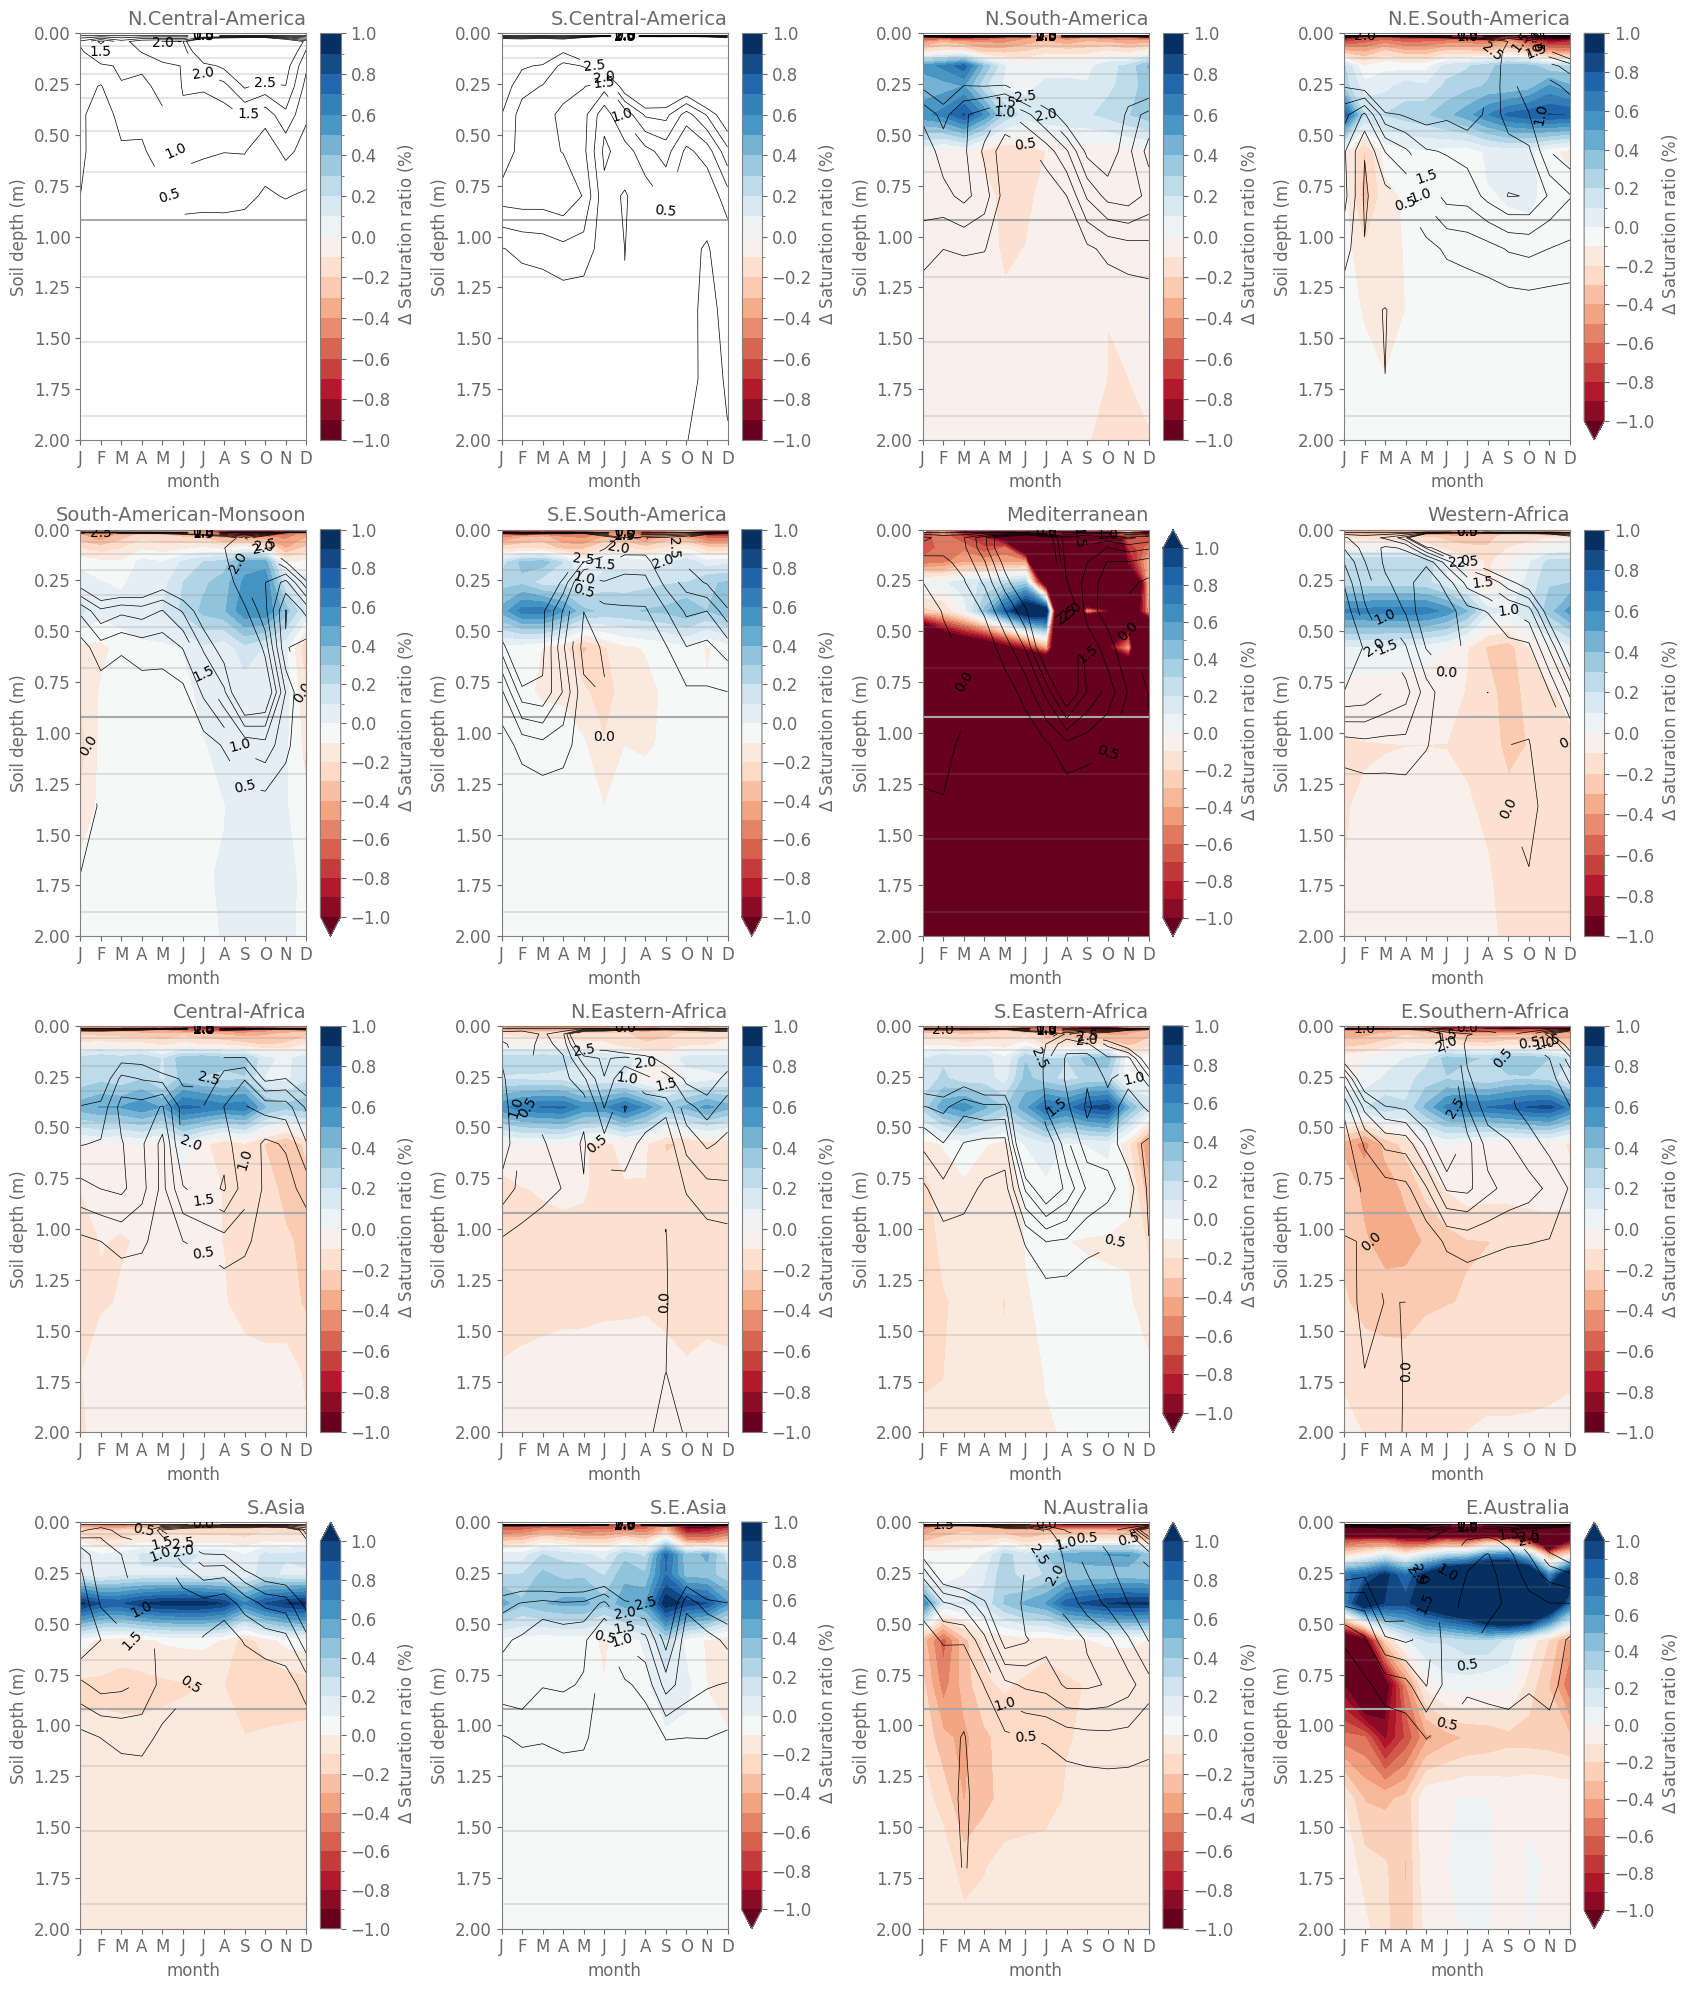

In [24]:
# prepare for plotting 
variable = 'satfrac'
# open regions dataset

if  isinstance(texture_mask,bool):
    texure_name = ''
else: 
    texture_name = texture_mask.name

print(texture_name)
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change_rel.nc')[variable]
da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()

variable = 'QROOTSINK'
da_ctl_region_qroot = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.ctl.nc')[variable]
da_ctl_region_qroot_seasmean = da_ctl_region_qroot.groupby('time.month').mean().squeeze()



fig, axes = plt.subplots(4,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-1,1.1,0.1)
    ticks =np.arange(-1,1.2,0.2)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ Saturation ratio (%)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

#### Absolute change

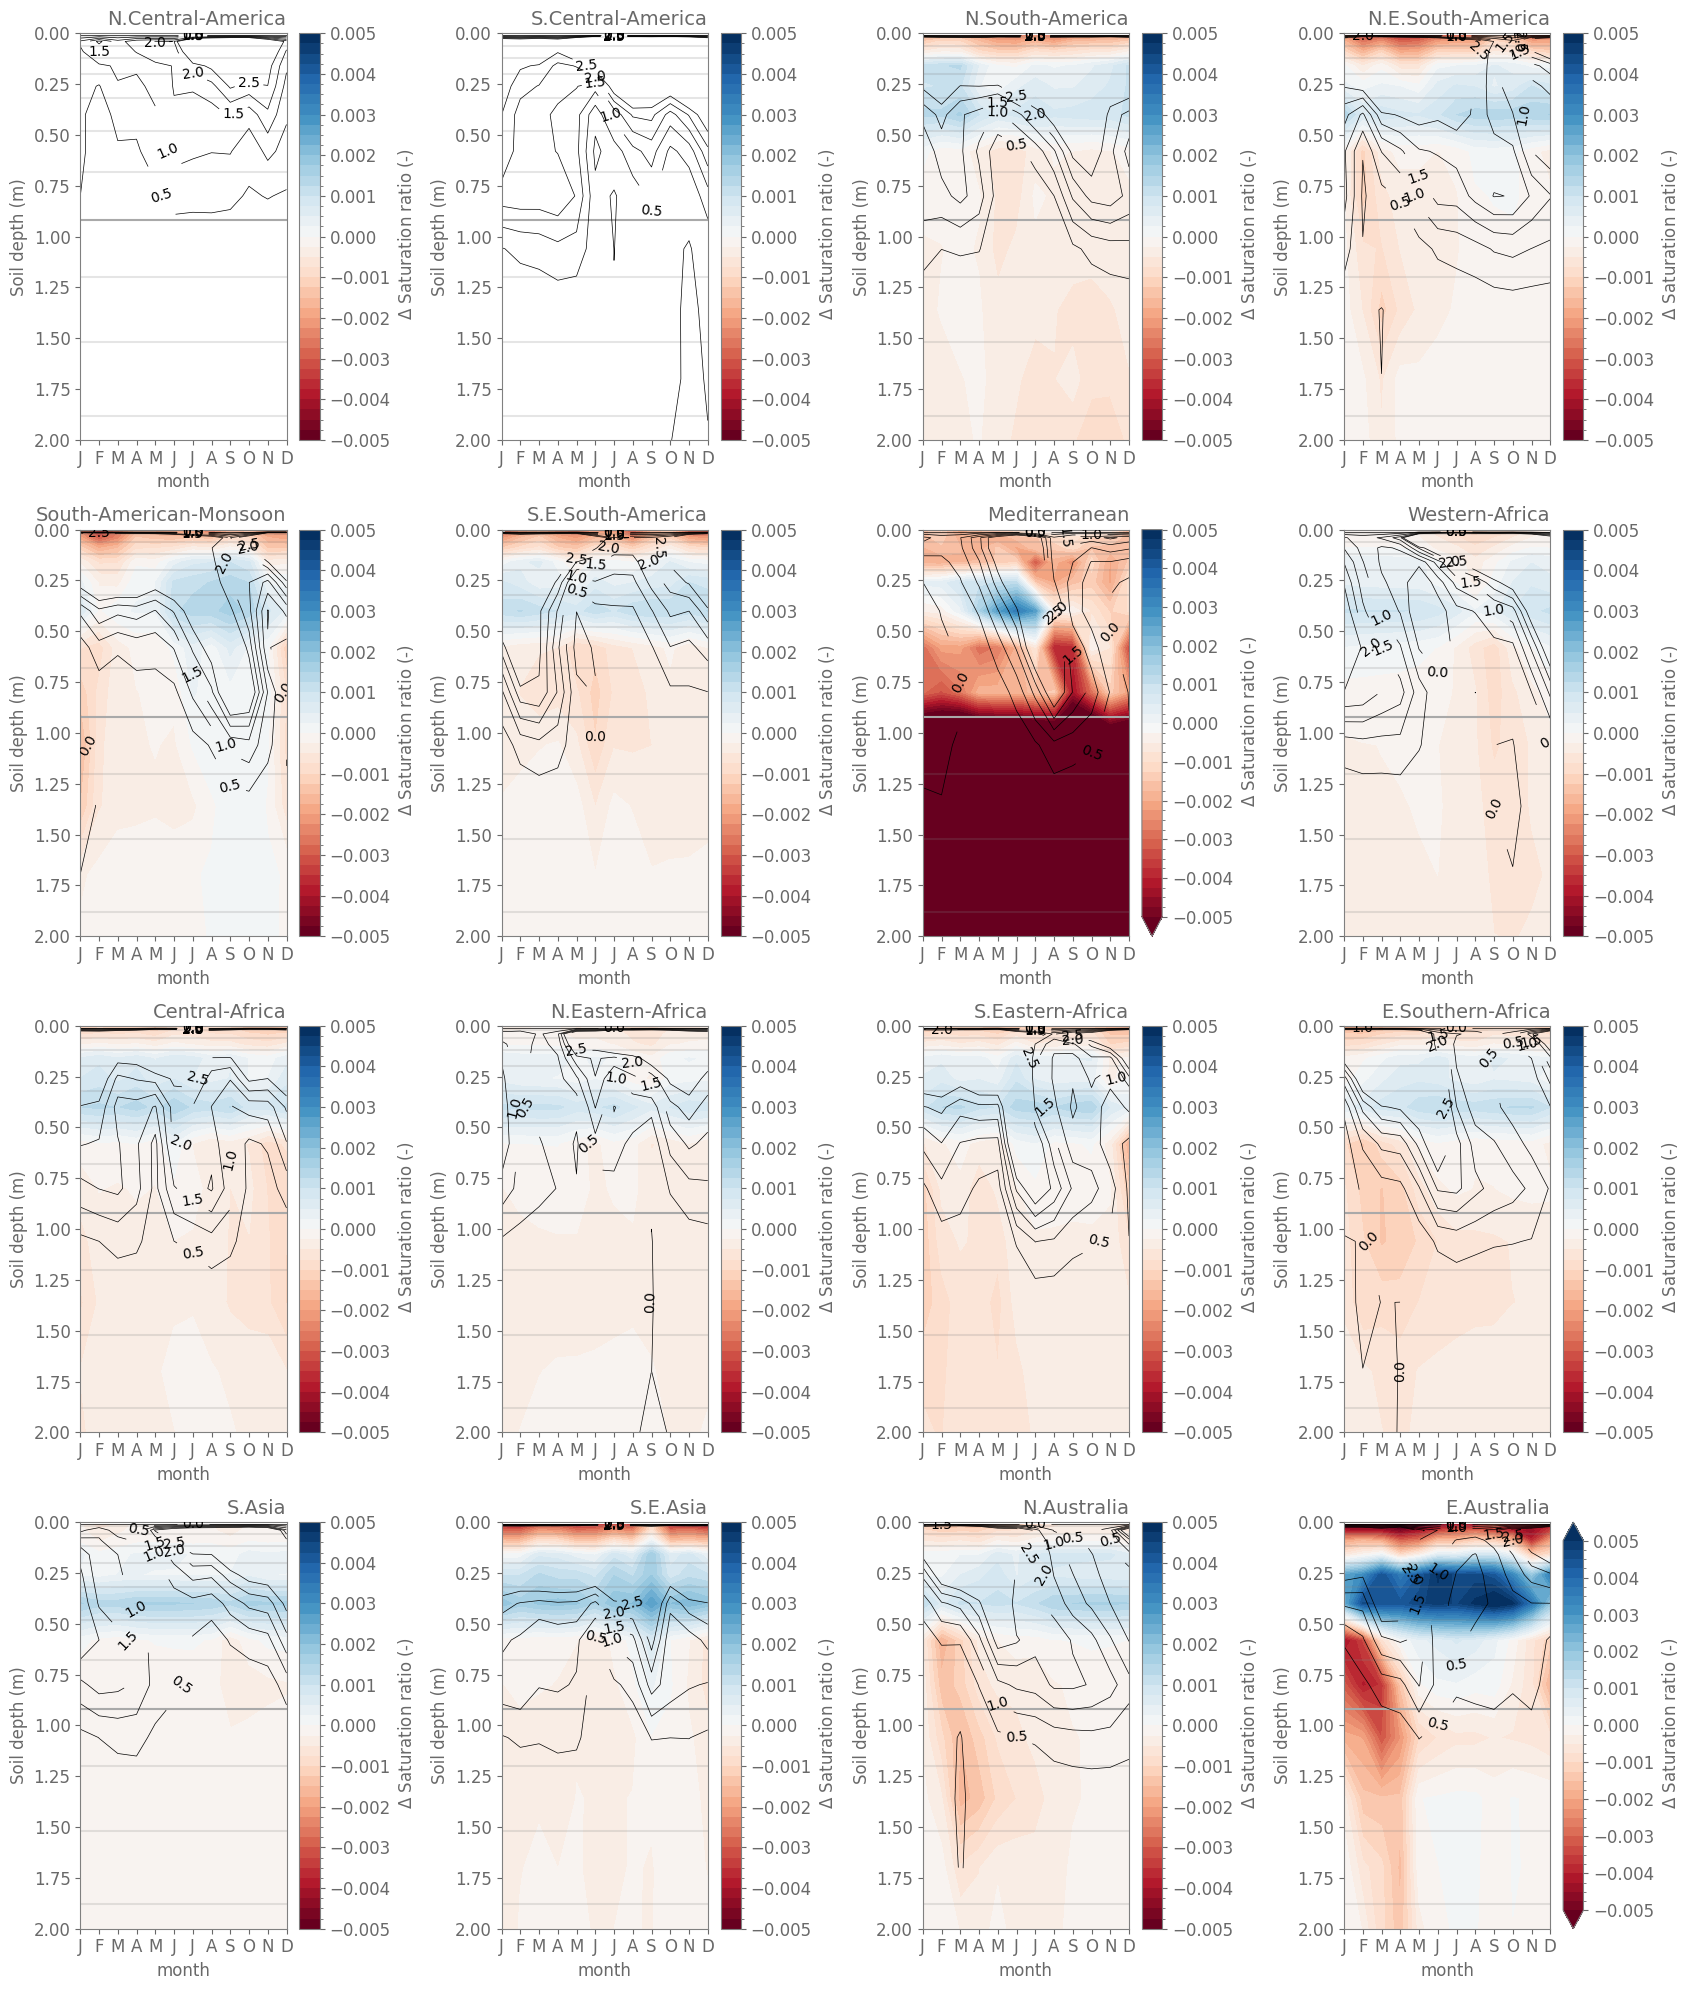

In [25]:
# prepare for plotting 
variable = 'satfrac'


if  isinstance(texture_mask,bool):
    texure_name = ''
else: 
    texture_name = texture_mask.name
    
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change.nc')[variable]
da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()


fig, axes = plt.subplots(4,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-0.005,0.00525,0.00025)
    ticks =np.arange(-0.005,0.006,0.001)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ Saturation ratio (-)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

### volumetric soil moisture

#### relative change

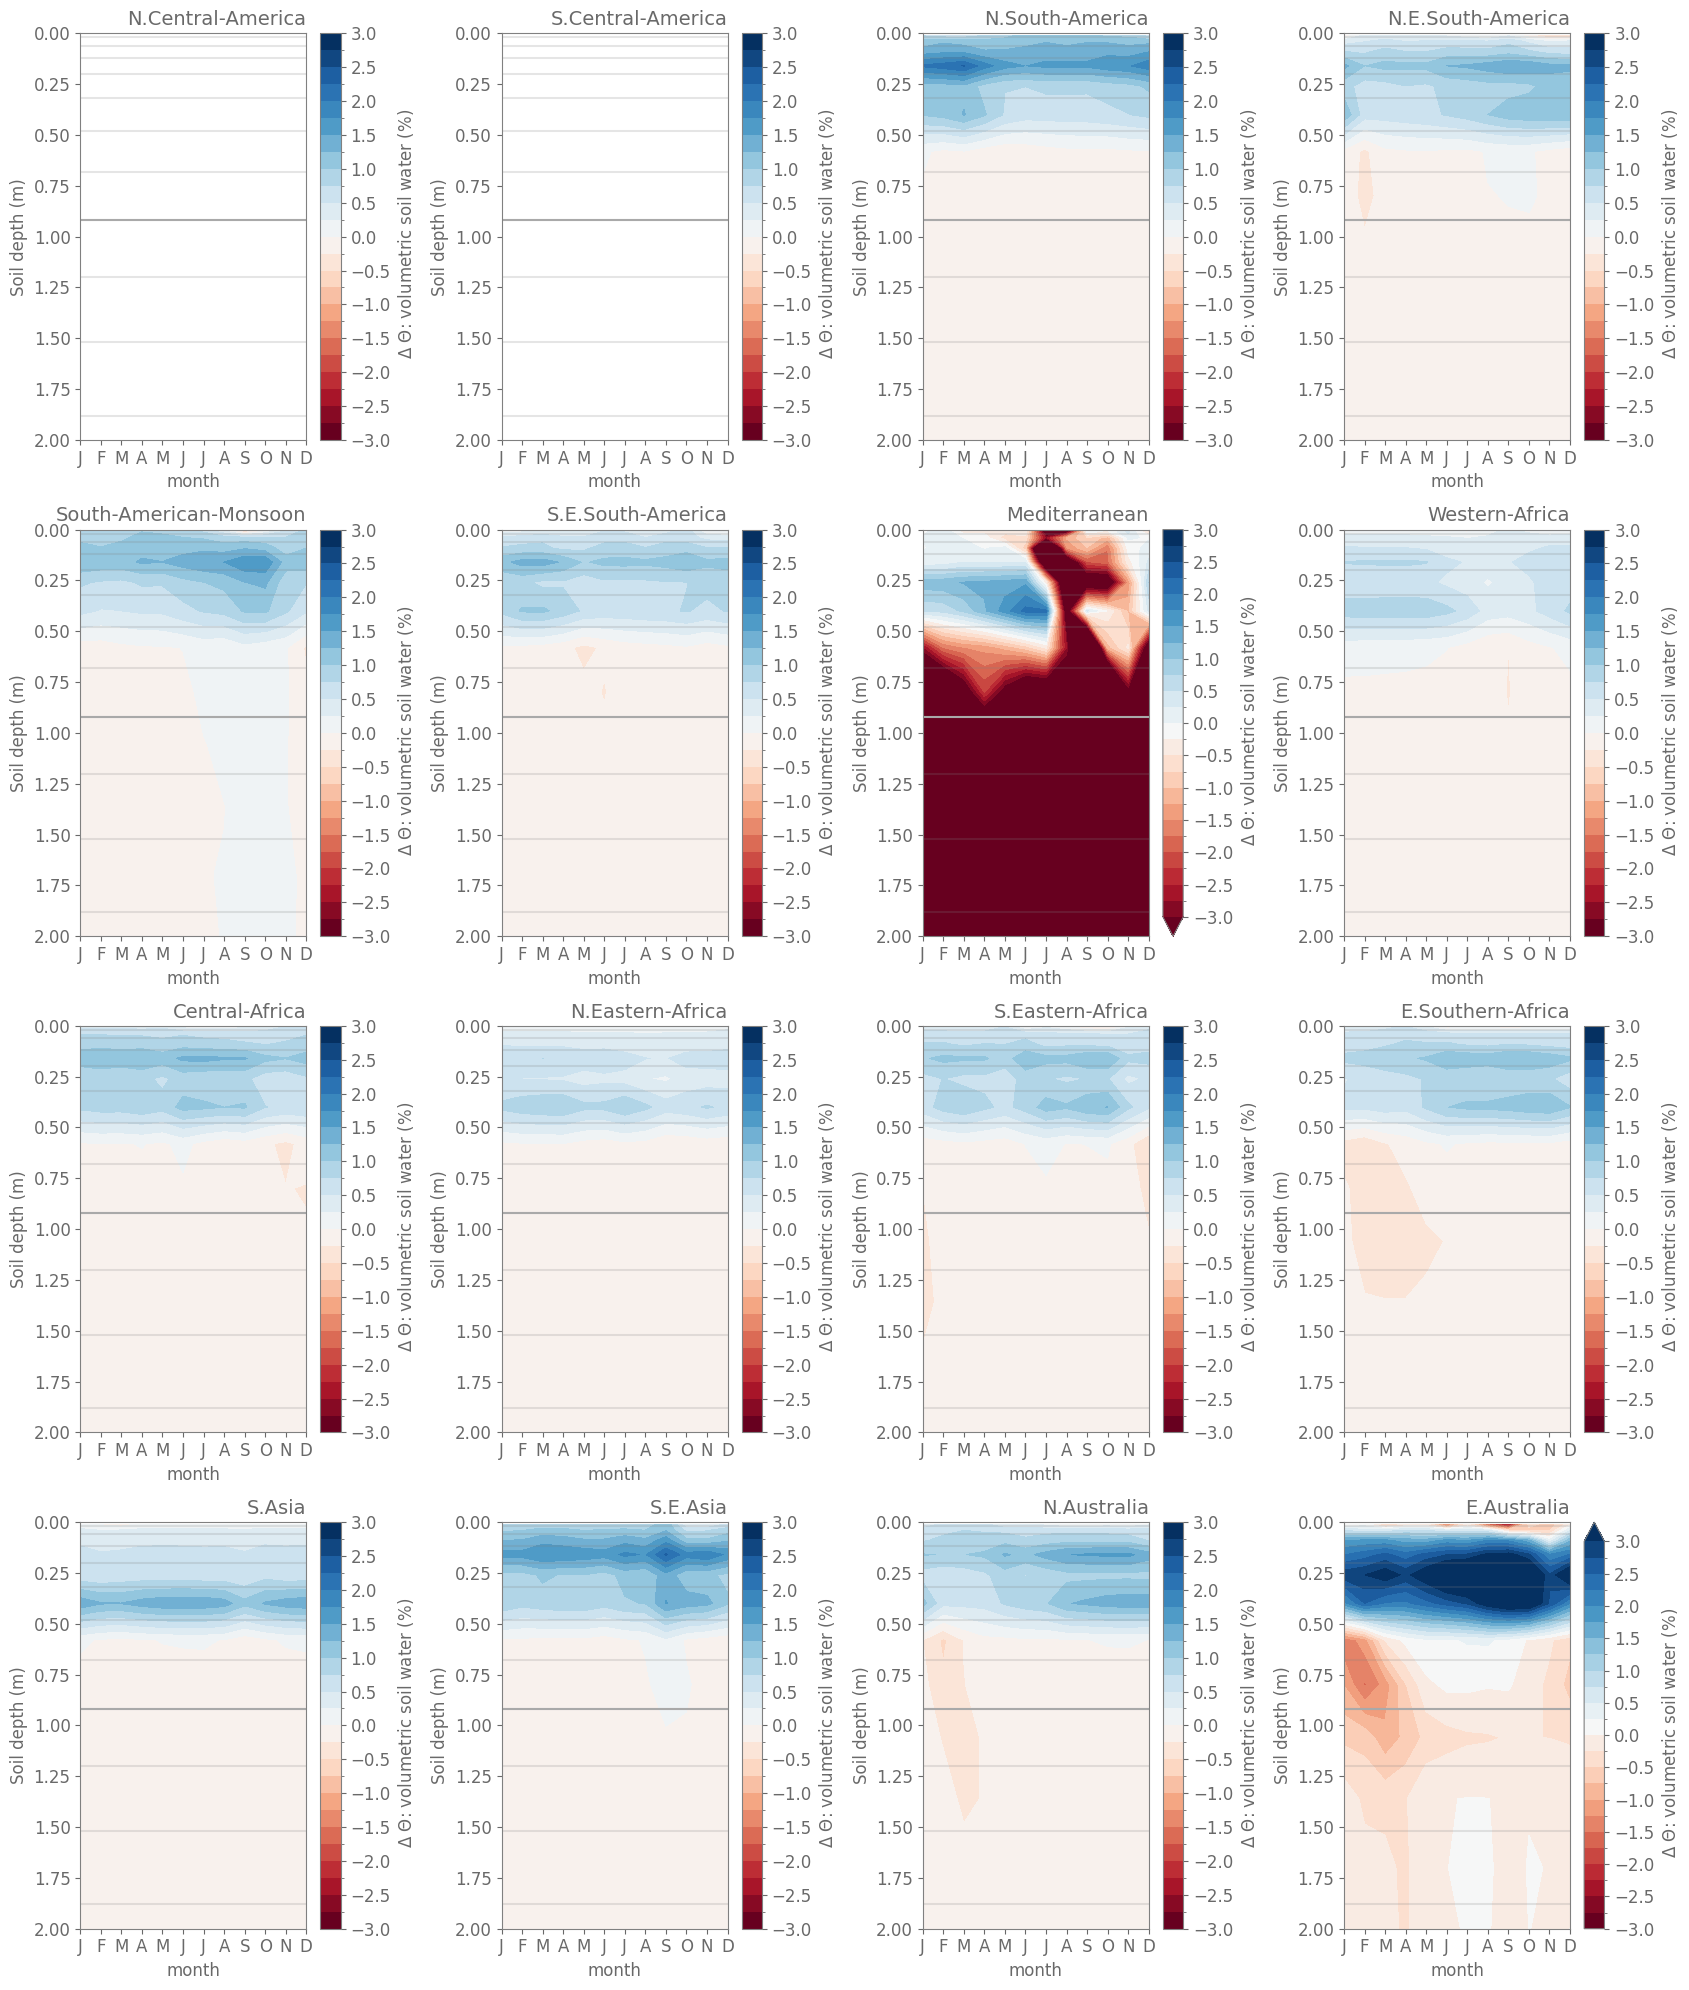

In [21]:
# prepare for plotting 
variable = 'H2OSOI'


if  isinstance(texture_mask,bool):
    texure_name = ''
else: 
    texture_name = texture_mask.name
    
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change_rel.nc')[variable]
da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()

fig, axes = plt.subplots(4,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-3,3.25,0.25)
    ticks =np.arange(-3,3.5,0.5)
    
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ $\Theta$: volumetric soil water (%)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

#### absolute change

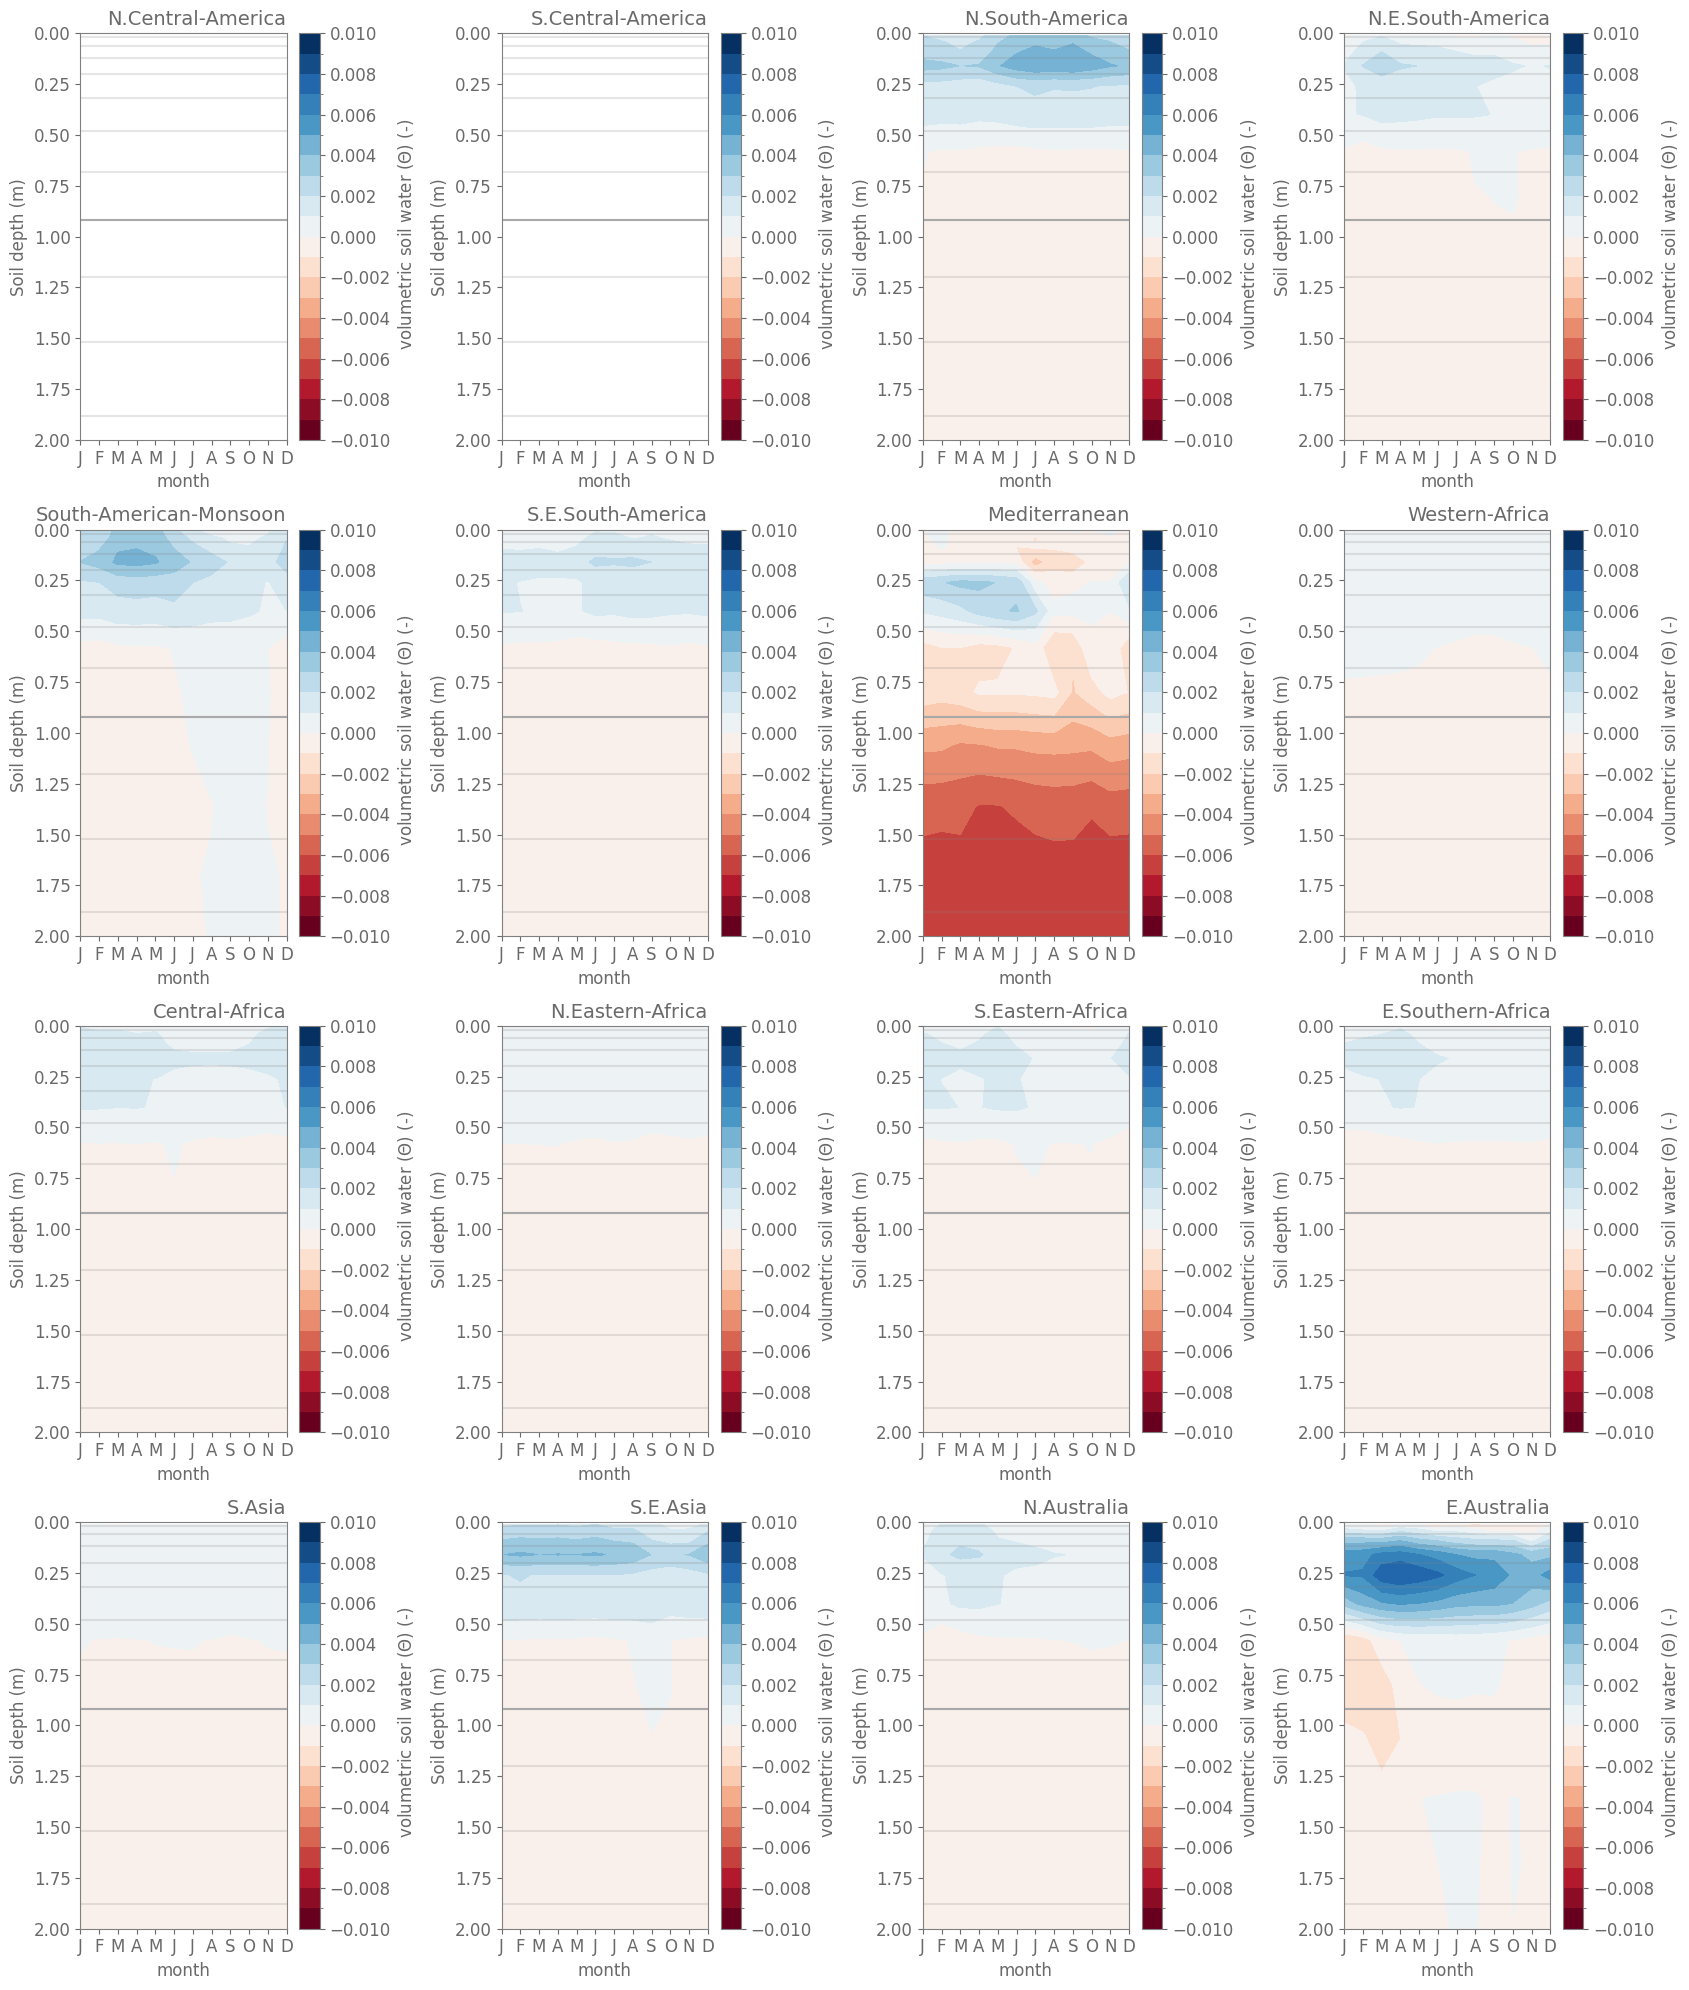

In [22]:
# prepare for plotting 
variable = 'H2OSOI'

if  isinstance(texture_mask,bool):
    texure_name = ''
else: 
    texture_name = texture_mask.name
    
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change.nc')[variable]
da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()

fig, axes = plt.subplots(4,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
    
    levels =np.arange(-0.01,0.011,0.001)
    ticks =np.arange(-0.01,0.012,0.002)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' volumetric soil water ($\Theta$) (-)', 'ticks':ticks}, levels= levels)
    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
      
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

## Clay soils



### saturated fraction

In [11]:
texture_mask = da_clay_mask
region_ids = regions_sand_clay

pft_int = pft_list_crops[0]

flag_plot_rootuptake = False

figsize = (17,20)

#### relative change

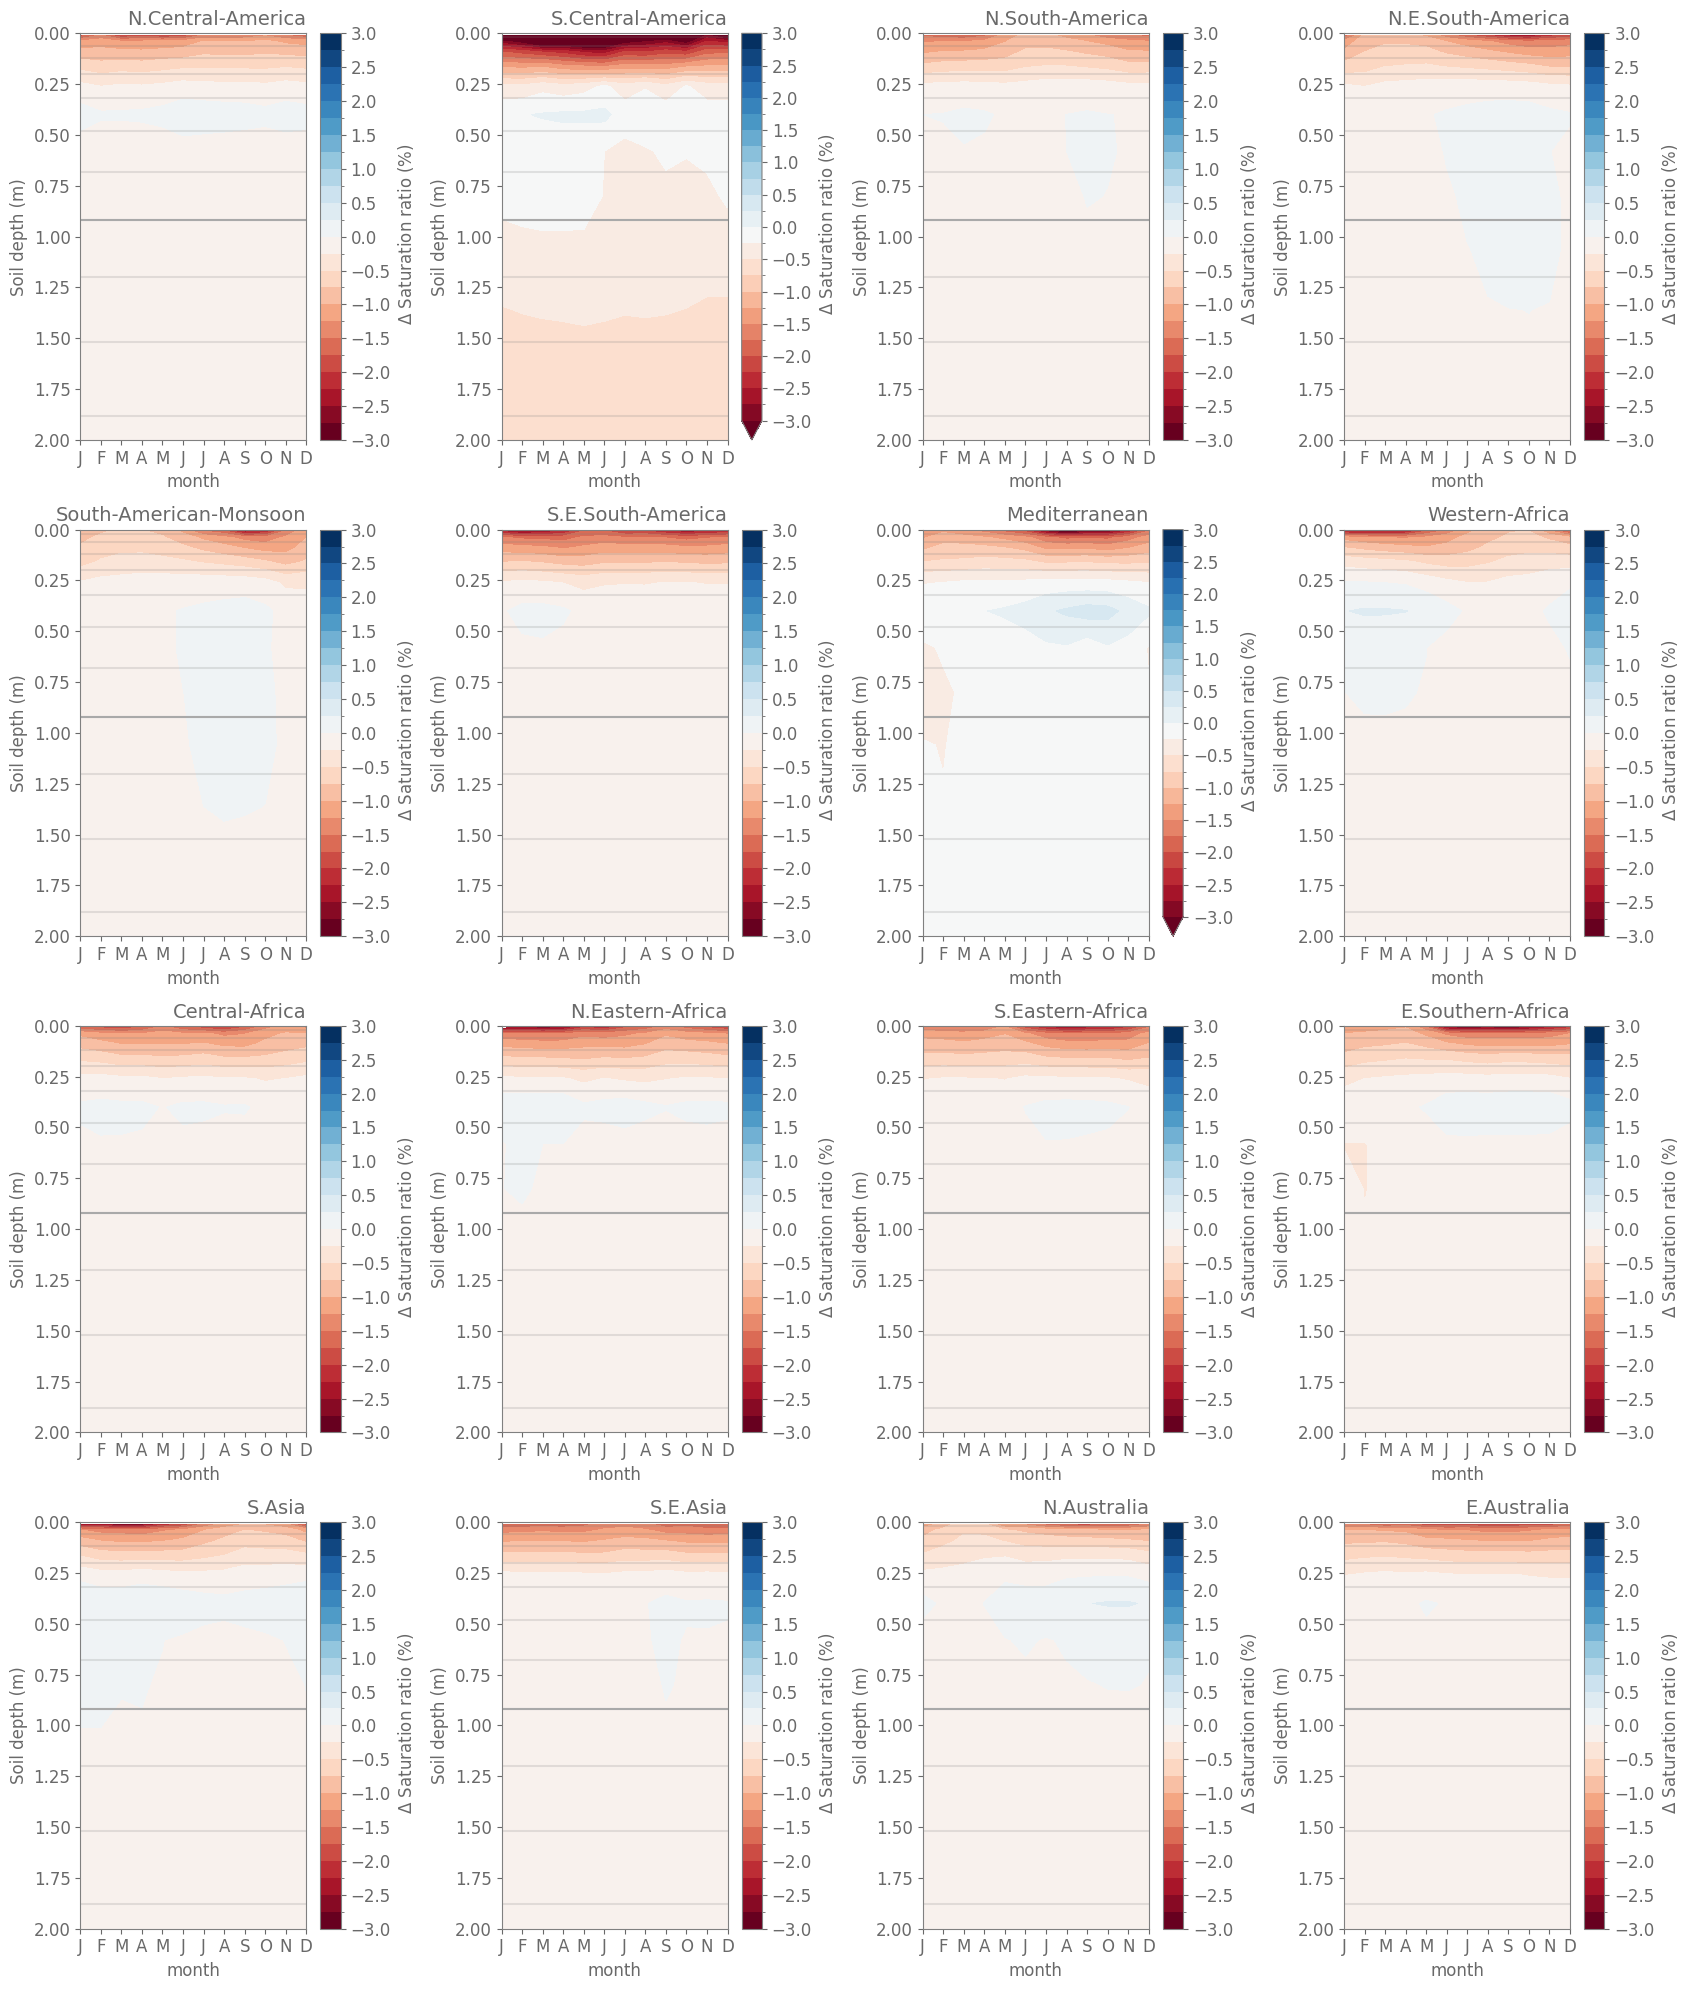

In [46]:
# prepare for plotting 
variable = 'satfrac'
# open regions dataset

if  isinstance(texture_mask,bool):
    texure_name = ''
else: 
    texture_name = texture_mask.name
    
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change_rel.nc')[variable]
da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()

variable = 'QROOTSINK'
da_ctl_region_qroot = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.ctl.nc')[variable]
da_ctl_region_qroot_seasmean = da_ctl_region_qroot.groupby('time.month').mean().squeeze()



fig, axes = plt.subplots(4,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-3,3.25,0.25)
    ticks =np.arange(-3,3.5,0.5)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ Saturation ratio (%)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

#### Absolute change

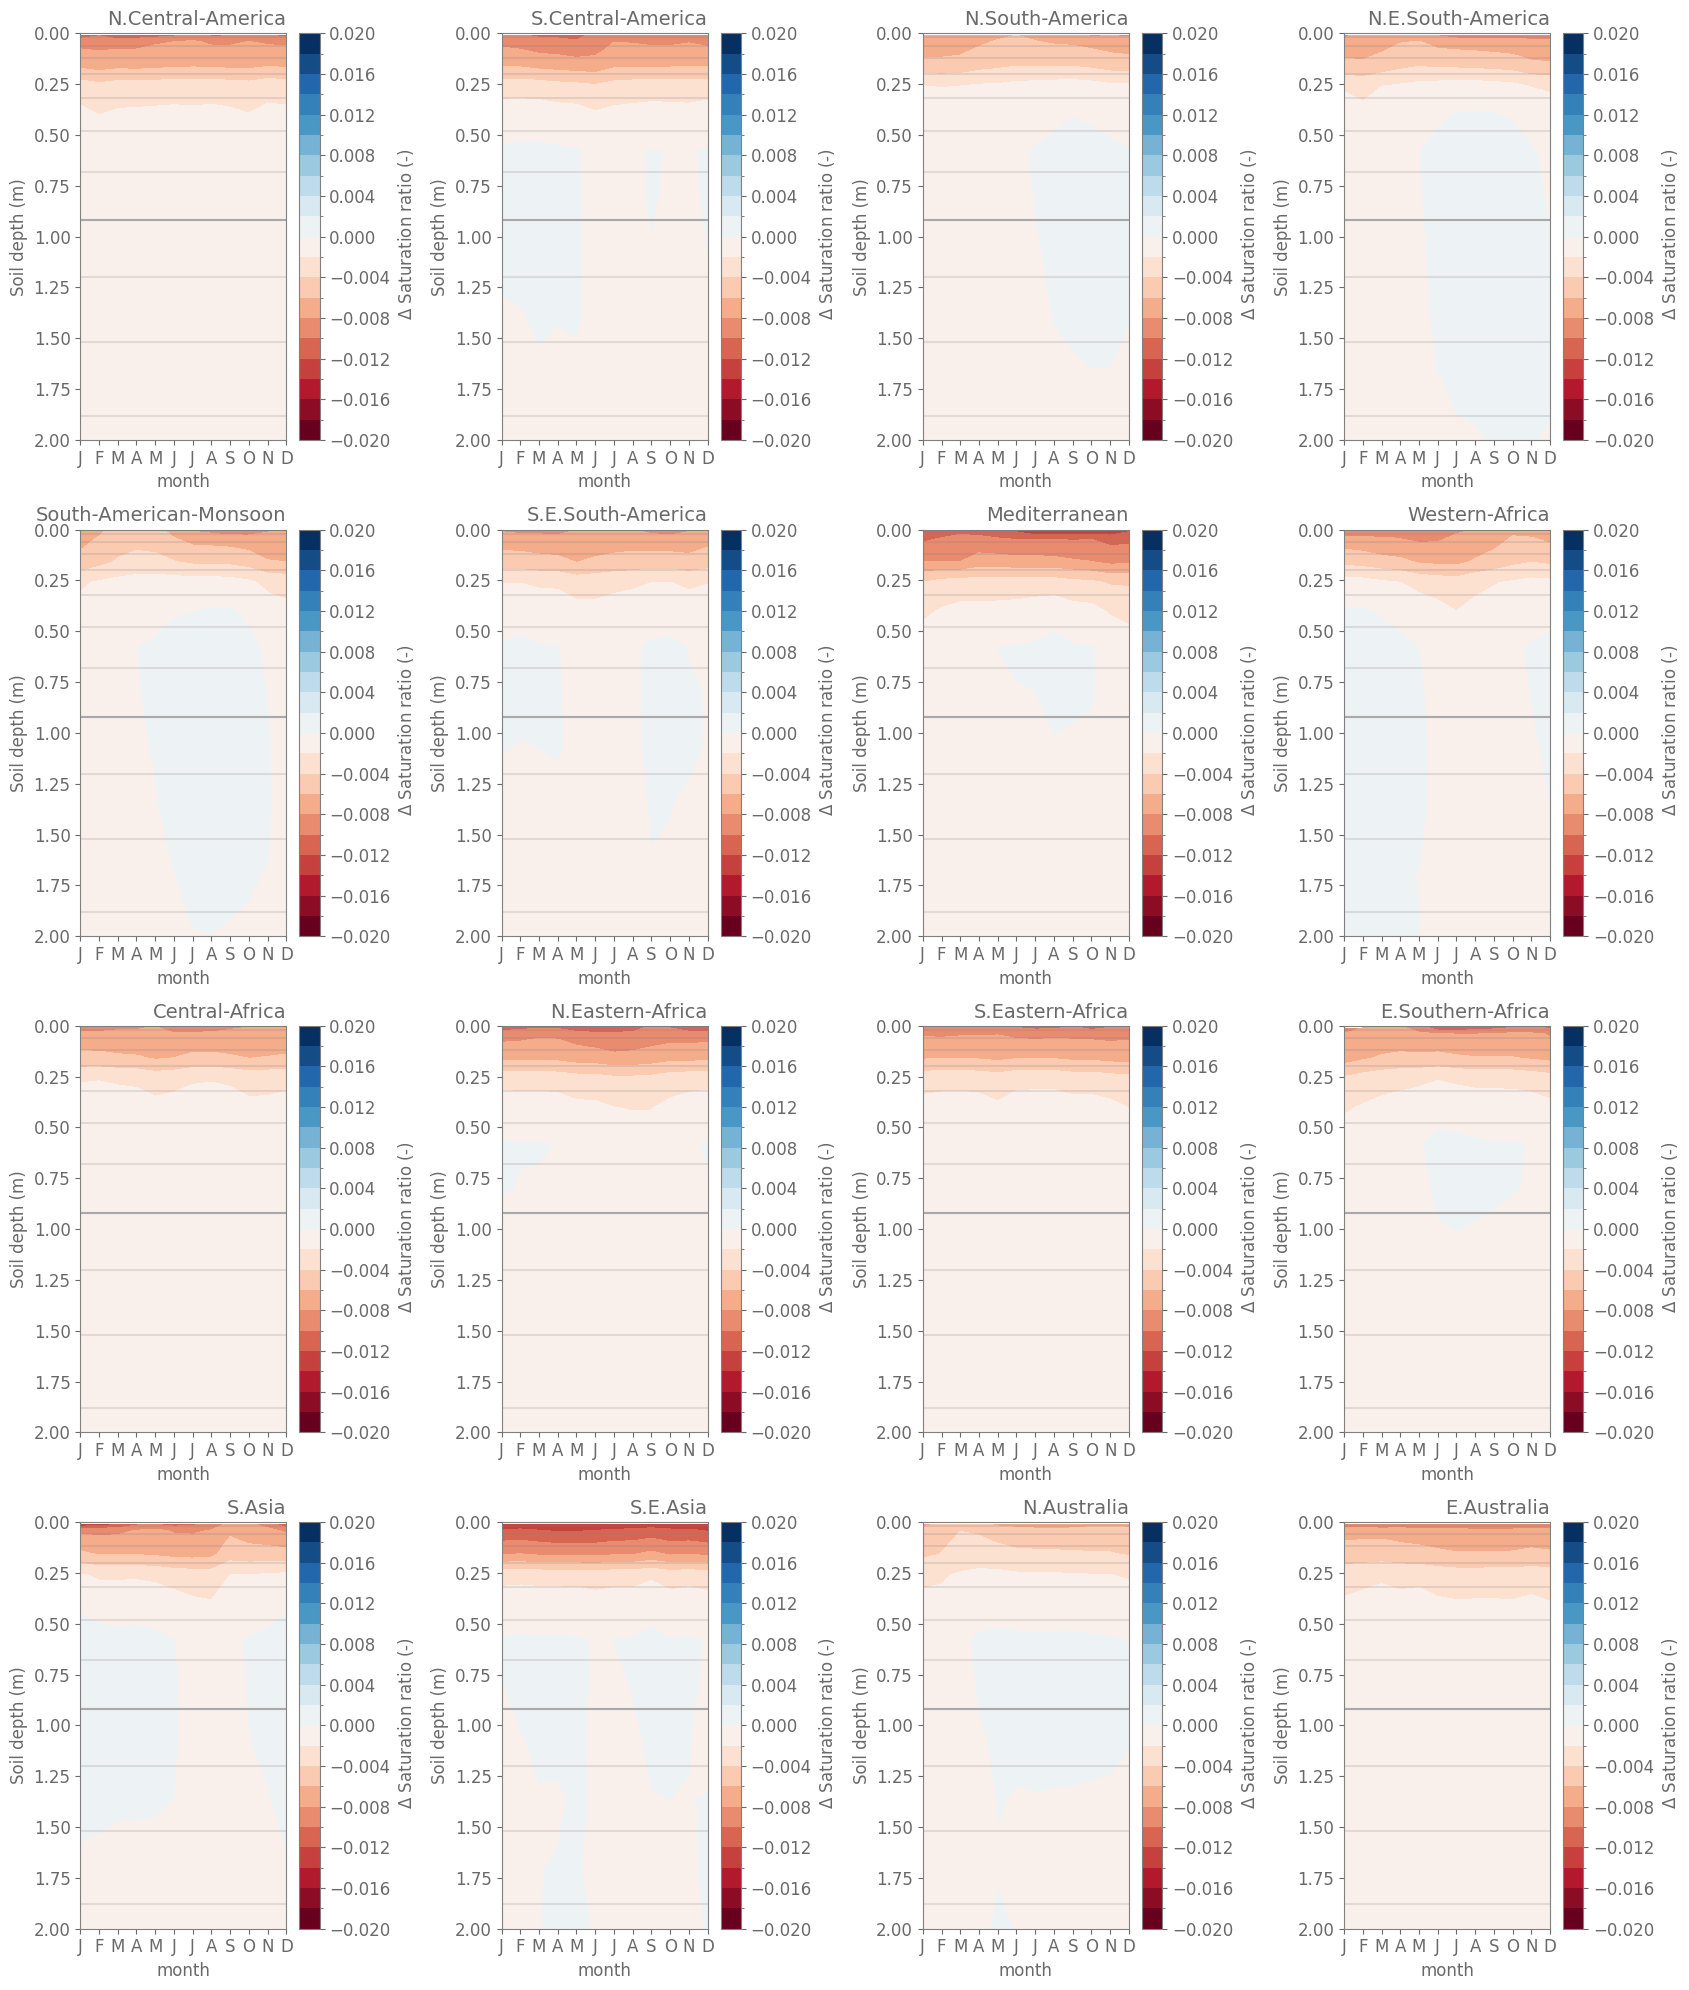

In [51]:
# prepare for plotting 
variable = 'satfrac'


if  isinstance(texture_mask,bool):
    texure_name = ''
else: 
    texture_name = texture_mask.name
    
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change.nc')[variable]
da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()


fig, axes = plt.subplots(4,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-0.02,0.022,0.002)
    ticks =np.arange(-0.02,0.024,0.004)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ Saturation ratio (-)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

### volumetric soil moisture

#### relative change

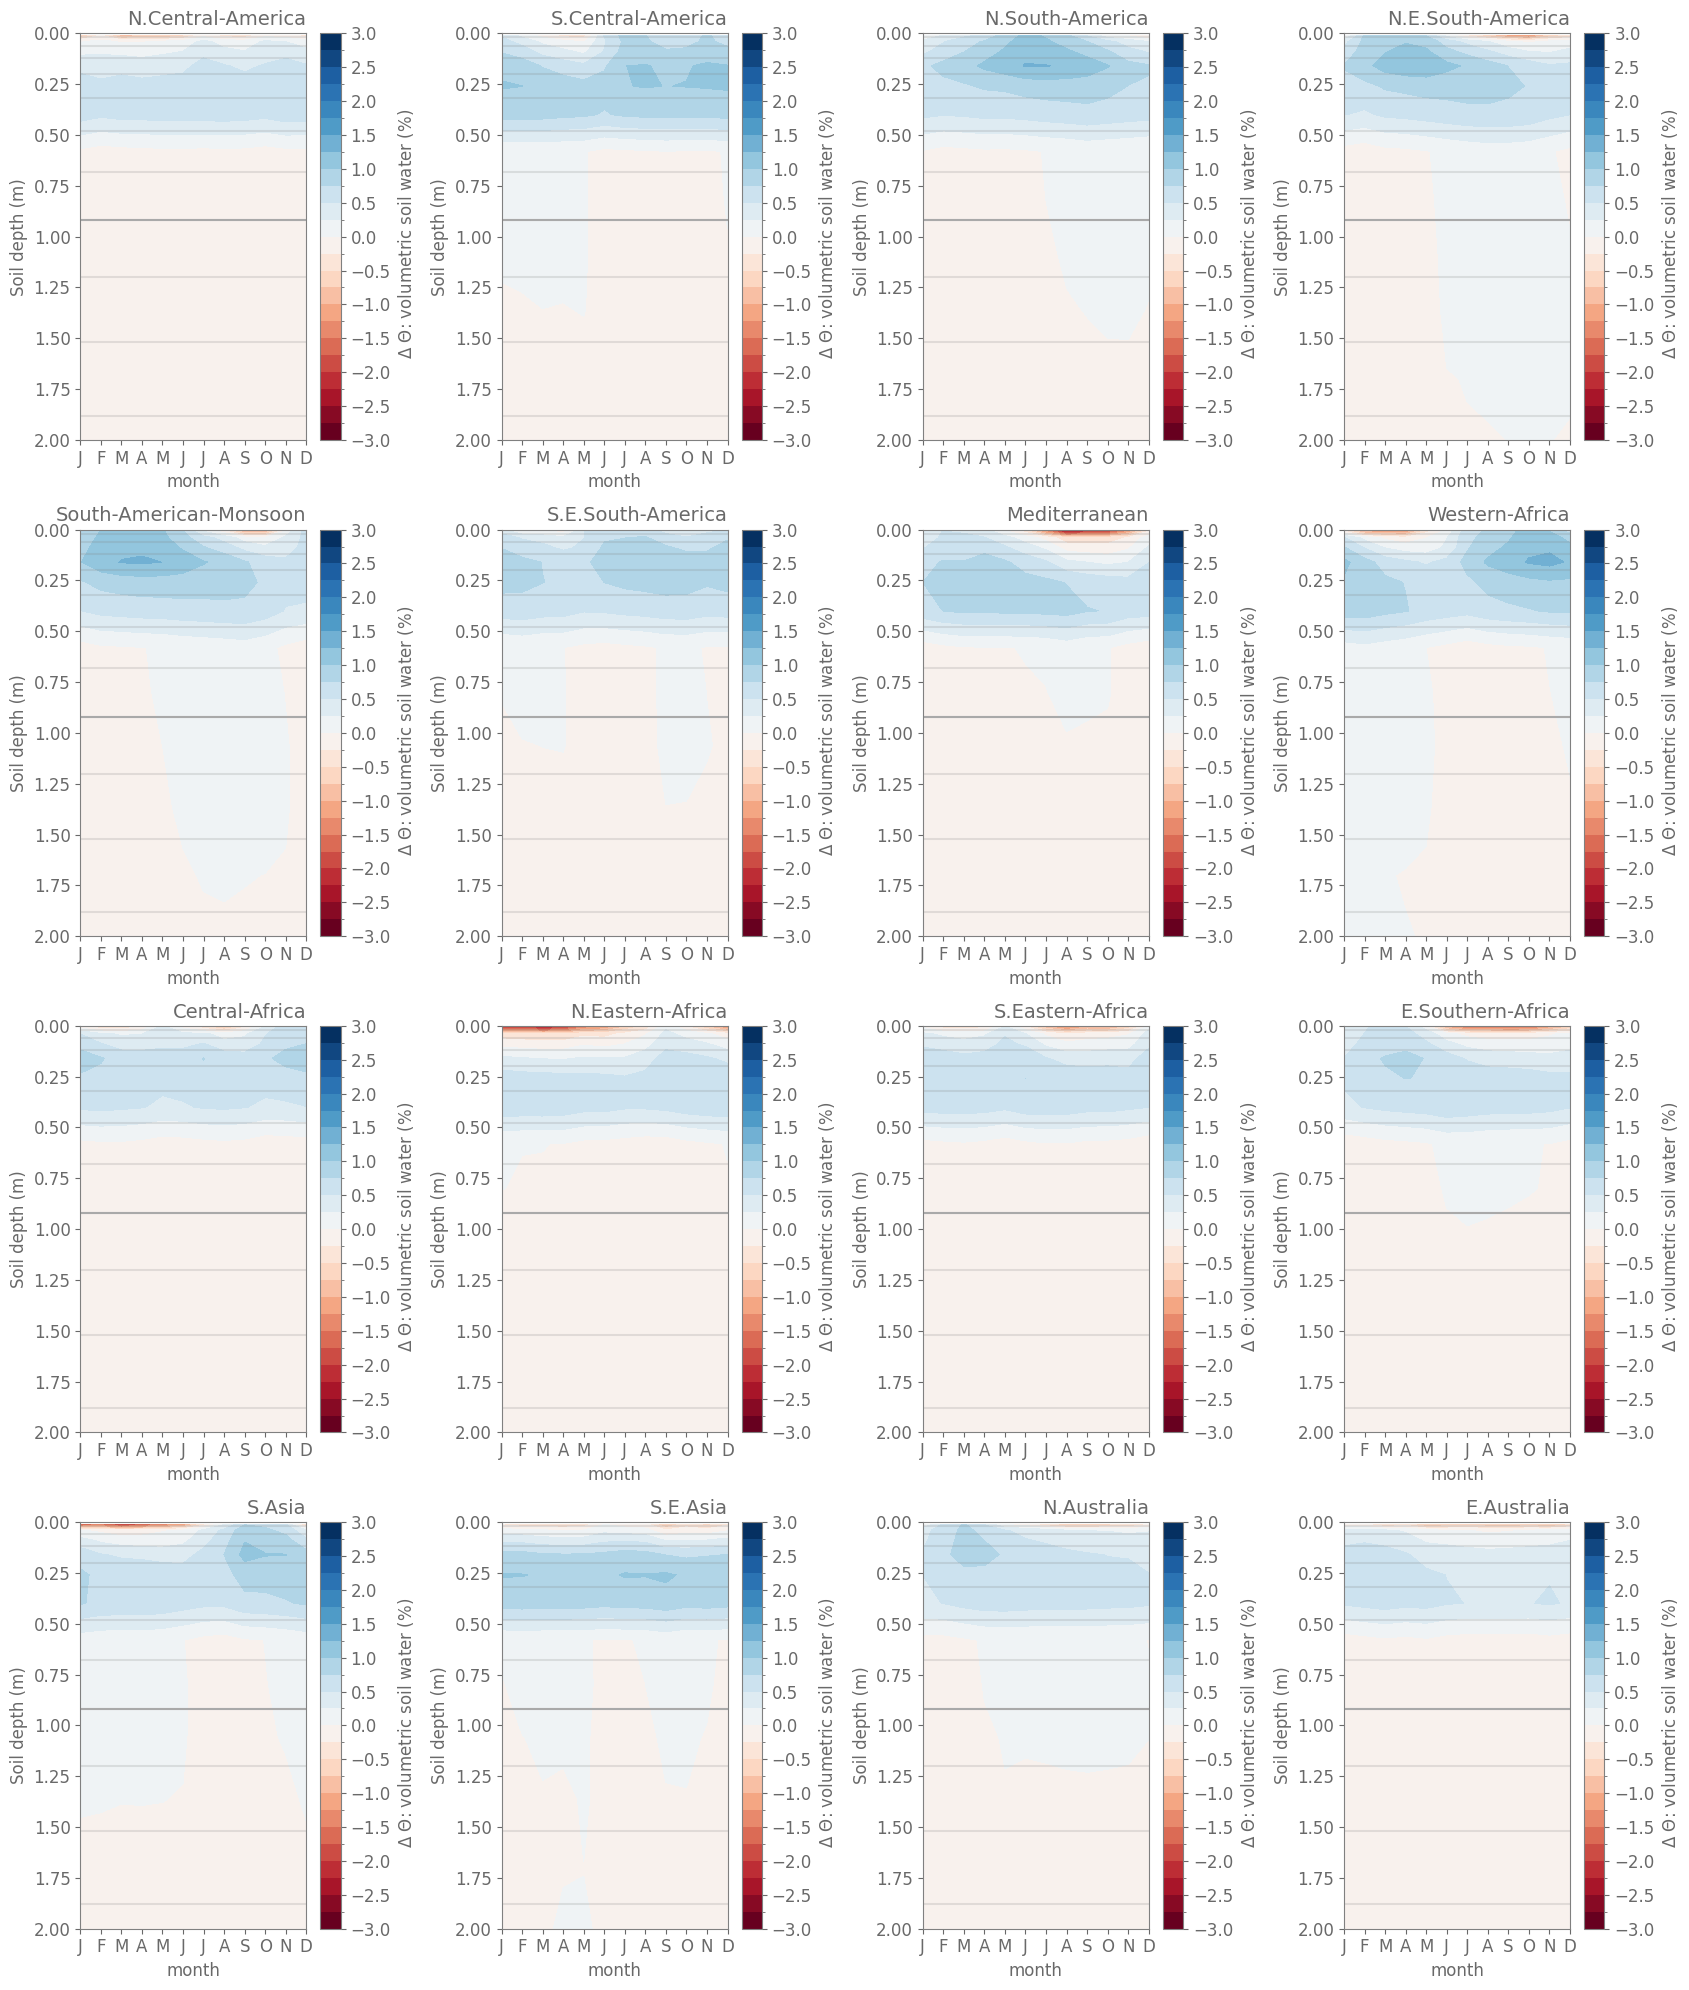

In [12]:
# prepare for plotting 
variable = 'H2OSOI'


if  isinstance(texture_mask,bool):
    texure_name = ''
else: 
    texture_name = texture_mask.name
    
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change_rel.nc')[variable]
da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()

fig, axes = plt.subplots(4,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

    
    levels =np.arange(-3,3.25,0.25)
    ticks =np.arange(-3,3.5,0.5)
    
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' $\Delta$ $\Theta$: volumetric soil water (%)', 'ticks':ticks}, levels= levels)

    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
    
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

#### absolute change

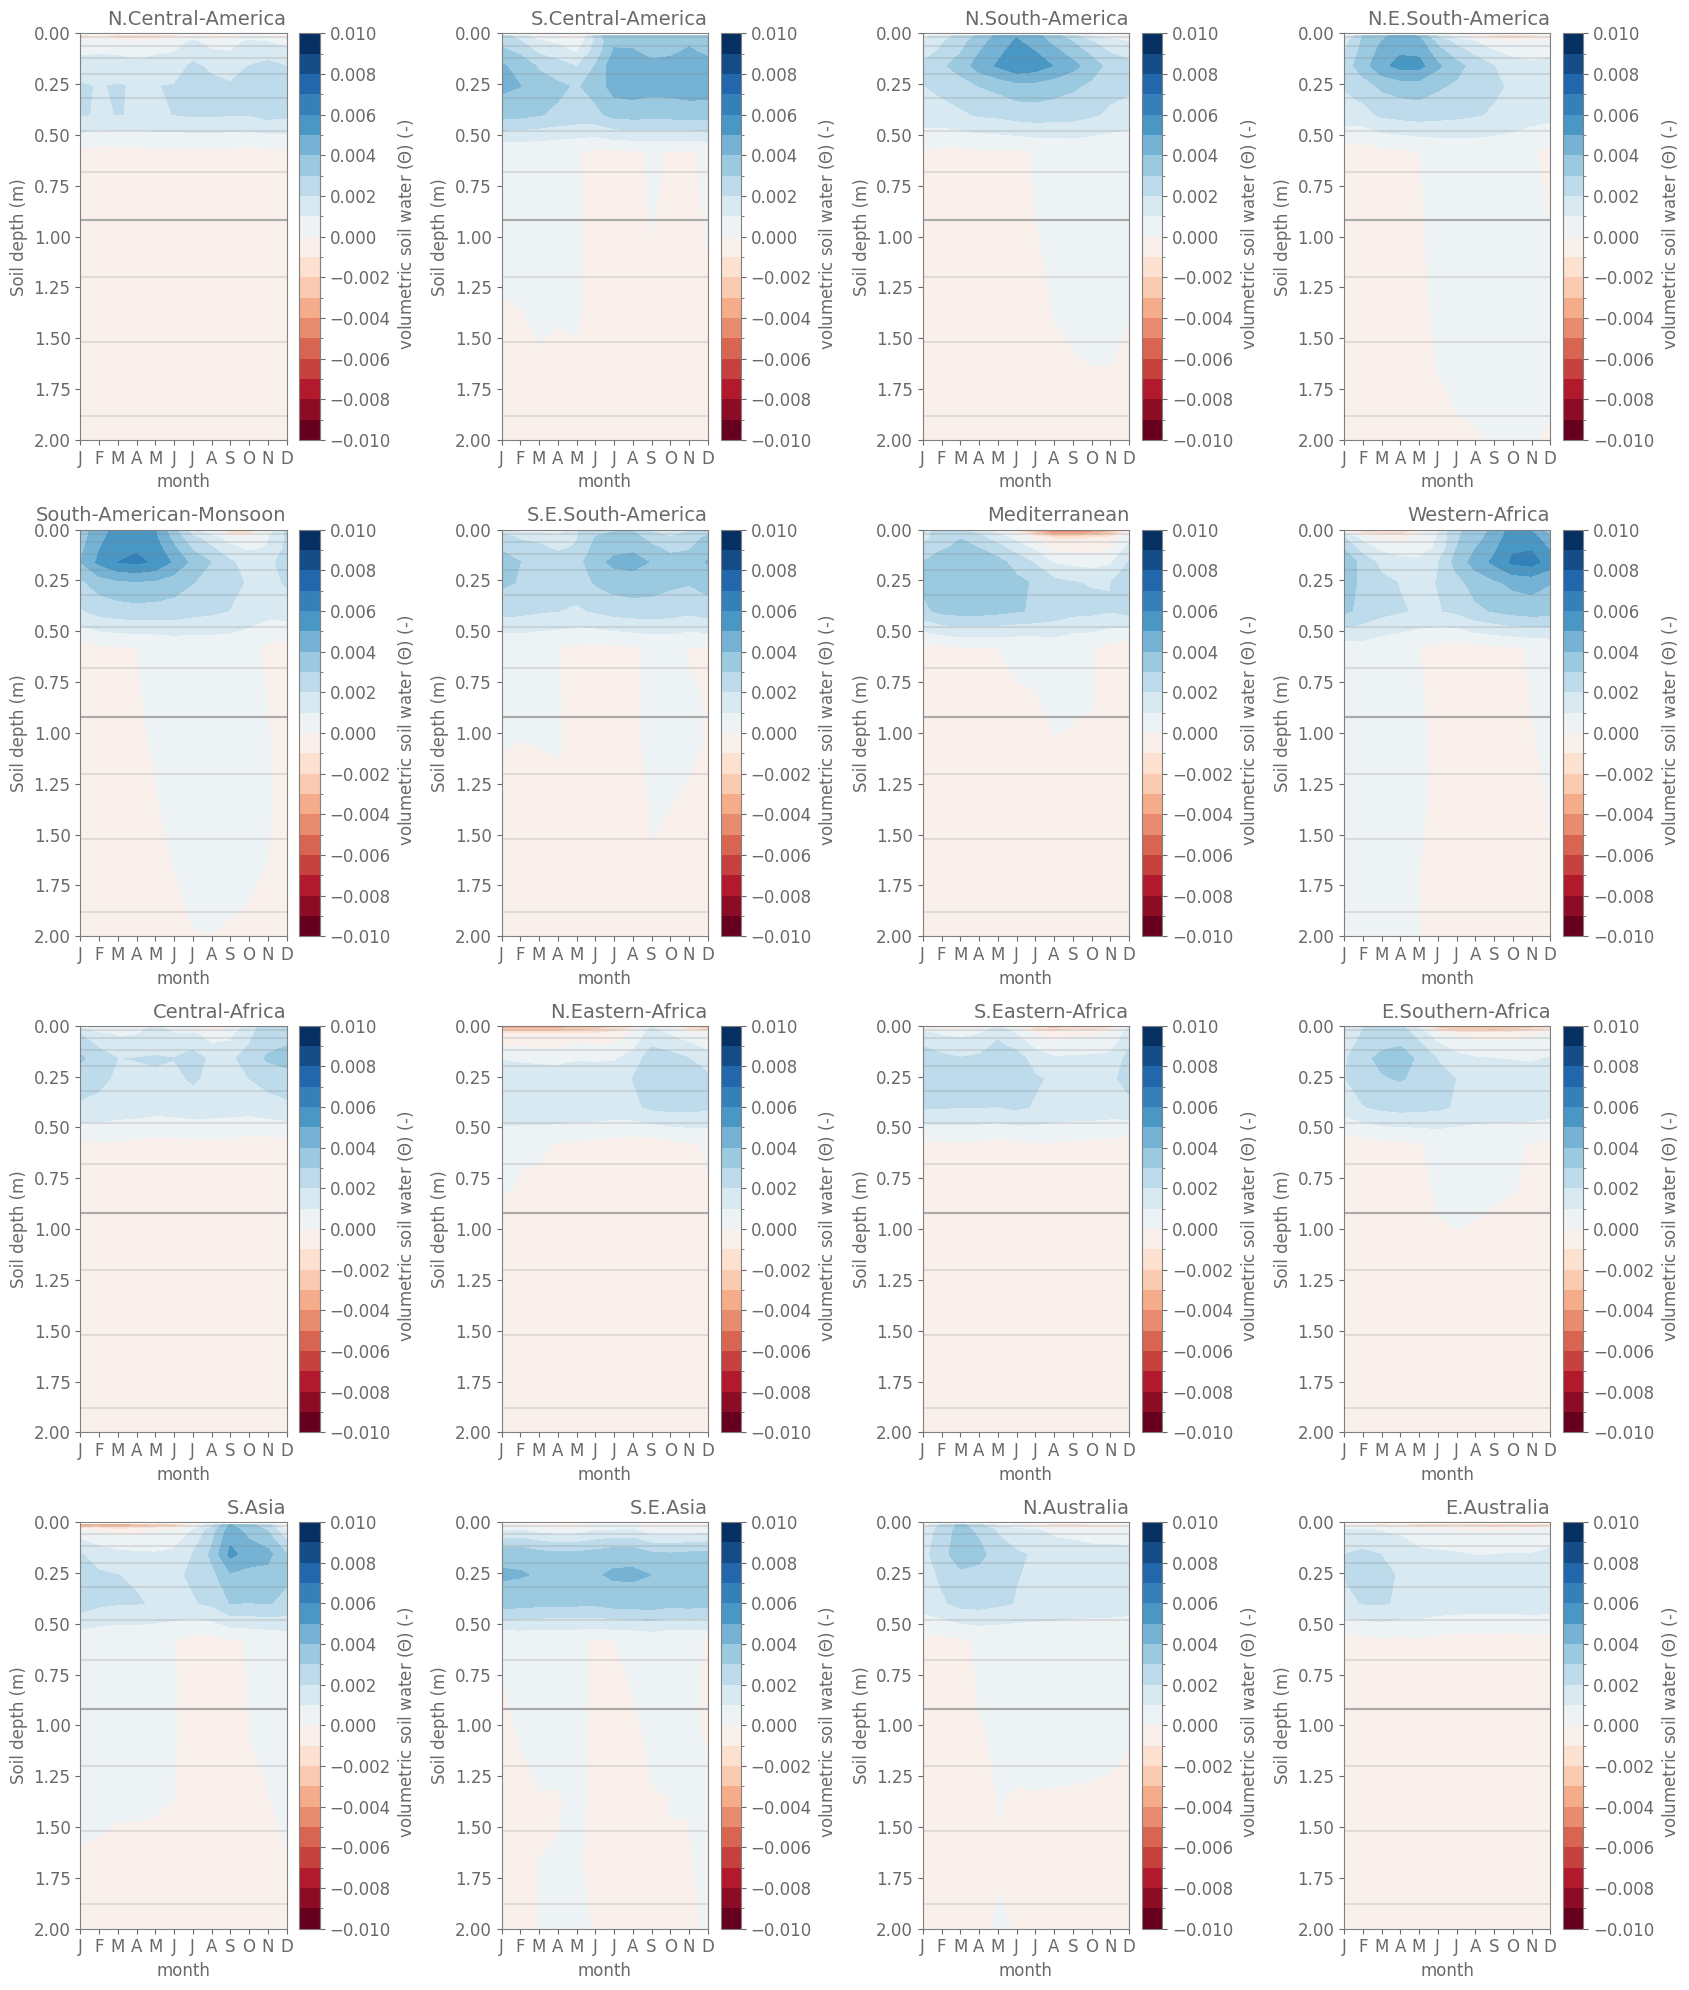

In [13]:
# prepare for plotting 
variable = 'H2OSOI'

if  isinstance(texture_mask,bool):
    texure_name = ''
else: 
    texture_name = texture_mask.name
    
da_regions = xr.open_dataset(procdir+'/postprocessing/pft_gridding/regional_means.'+variable+'.'+str(pft_int)+'.'+texture_name+'.delta_change.nc')[variable]
da_regions_seasmean = da_regions.groupby('time.month').mean().squeeze()

fig, axes = plt.subplots(4,4,figsize=figsize)
axes = axes.flatten()

for i, region in enumerate(region_ids):
    
    ax = axes[i]

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
    
    levels =np.arange(-0.01,0.011,0.001)
    ticks =np.arange(-0.01,0.012,0.002)
    
    da_regions_seasmean.sel(region=region).plot.contourf(ax=ax, x='month', y='levsoi', cmap='RdBu', cbar_kwargs={'label':' volumetric soil water ($\Theta$) (-)', 'ticks':ticks}, levels= levels)
    ax.hlines(levsoi_depth, 1,12, color='grey', alpha=0.2)
    ax.hlines(levsoi_depth[7],1,12, color='darkgrey', alpha=1)
      
    # plot QROOT
    if flag_plot_rootuptake: 
        levels_qroot = np.arange(0,2.75e-6,0.5e-6)
        cs = da_ctl_region_qroot_seasmean.sel(region=region).plot.contour(ax=ax,  x='month', y='levsoi', label='Root water uptake', levels=levels_qroot, linewidths=0.5, colors='k') #, colors='dimgray')
        ax.clabel(cs, inline=True, fontsize=10)

    ax.set_ylim([plotting_depth,0])
    ax.set_title(region_name, loc='right')
    ax.set_title(' ', loc='center')
    ax.set_ylabel('Soil depth (m)')
    ax.set_xticks(np.arange(1,13))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    fig.tight_layout()

## Look at infiltration for cropland

In [14]:
variable = 'QINFL'
pft_list = pft_list_crops


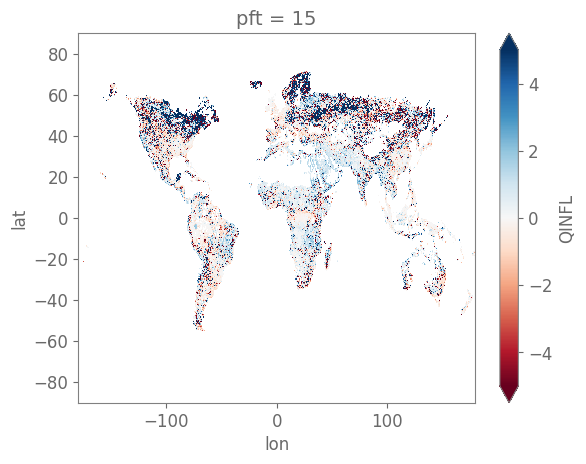

In [9]:
ds_delta, ds_delta_rel = calc_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list)

ds_delta_rel.mean('time').sel(pft=pft_list[0]).plot(vmin=-5,vmax=5, cmap='RdBu')



#### 

In [ ]:
# calculate delta and relative delta for pft output gridded variables after calculating regional means (avoiding inf values)
def calc_region_seasmean_delta_and_rel_pft(case_ctl,case_scen,variable,pft_list, region_mask, region_ids, texture_mask=False):

    list_da_pft = []
    list_da_pft_scen = []

    for pft_int in pft_list: 

        list_da_pft.append(load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable))
        list_da_pft_scen.append(load_da_gridded_pft(variable, pft_int, case_scen).rename(variable))

    ds_ctl = xr.concat(list_da_pft, dim='ivt_str').rename({'ivt_str':'pft'})
    ds_ctl['pft'] = pft_list

    ds_scen = xr.concat(list_da_pft_scen, dim='ivt_str').rename({'ivt_str':'pft'})
    ds_scen['pft'] = pft_list

    # texture mask is provided
    if not isinstance(texture_mask,bool):     
        ds_ctl = ds_ctl.where(texture_mask)
        ds_scen = ds_scen.where(texture_mask)

    d_delta = {}
    d_delta_rel= {}

    for i,region in enumerate(region_ids):

        region_name = regionmask.defined_regions.ar6.land[region].name
        region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev

        print('processing: '+ region_name)


        d_delta[region] = ds_scen.groupby('time.month').mean().where(mask_regions==region).mean(dim=('lat','lon')) - ds_ctl.groupby('time.month').mean().where(mask_regions==region).mean(dim=('lat','lon'))
        d_delta_rel[region] = (d_delta[region]/ ds_ctl.groupby('time.month').mean().where(mask_regions==region).mean(dim=('lat','lon')))*100
    return d_delta, d_delta_rel

In [11]:
d_delta_region, d_delta_rel_region = calc_region_seasmean_delta_and_rel_pft(case_ctl, case_scen, variable, pft_list, mask_regions, region_ids)

processing: W.North-America
processing: C.North-America
processing: E.North-America
processing: N.Central-America
processing: S.Central-America
processing: Caribbean
processing: N.W.South-America
processing: N.South-America
processing: N.E.South-America
processing: South-American-Monsoon
processing: S.W.South-America
processing: S.E.South-America
processing: S.South-America
processing: West&Central-Europe
processing: E.Europe
processing: Mediterranean
processing: Sahara
processing: Western-Africa
processing: Central-Africa
processing: N.Eastern-Africa
processing: S.Eastern-Africa
processing: W.Southern-Africa
processing: E.Southern-Africa
processing: Madagascar
processing: W.C.Asia
processing: E.C.Asia
processing: Tibetan-Plateau
processing: E.Asia
processing: Arabian-Peninsula
processing: S.Asia
processing: S.E.Asia
processing: N.Australia
processing: C.Australia
processing: E.Australia
processing: S.Australia
processing: New-Zealand


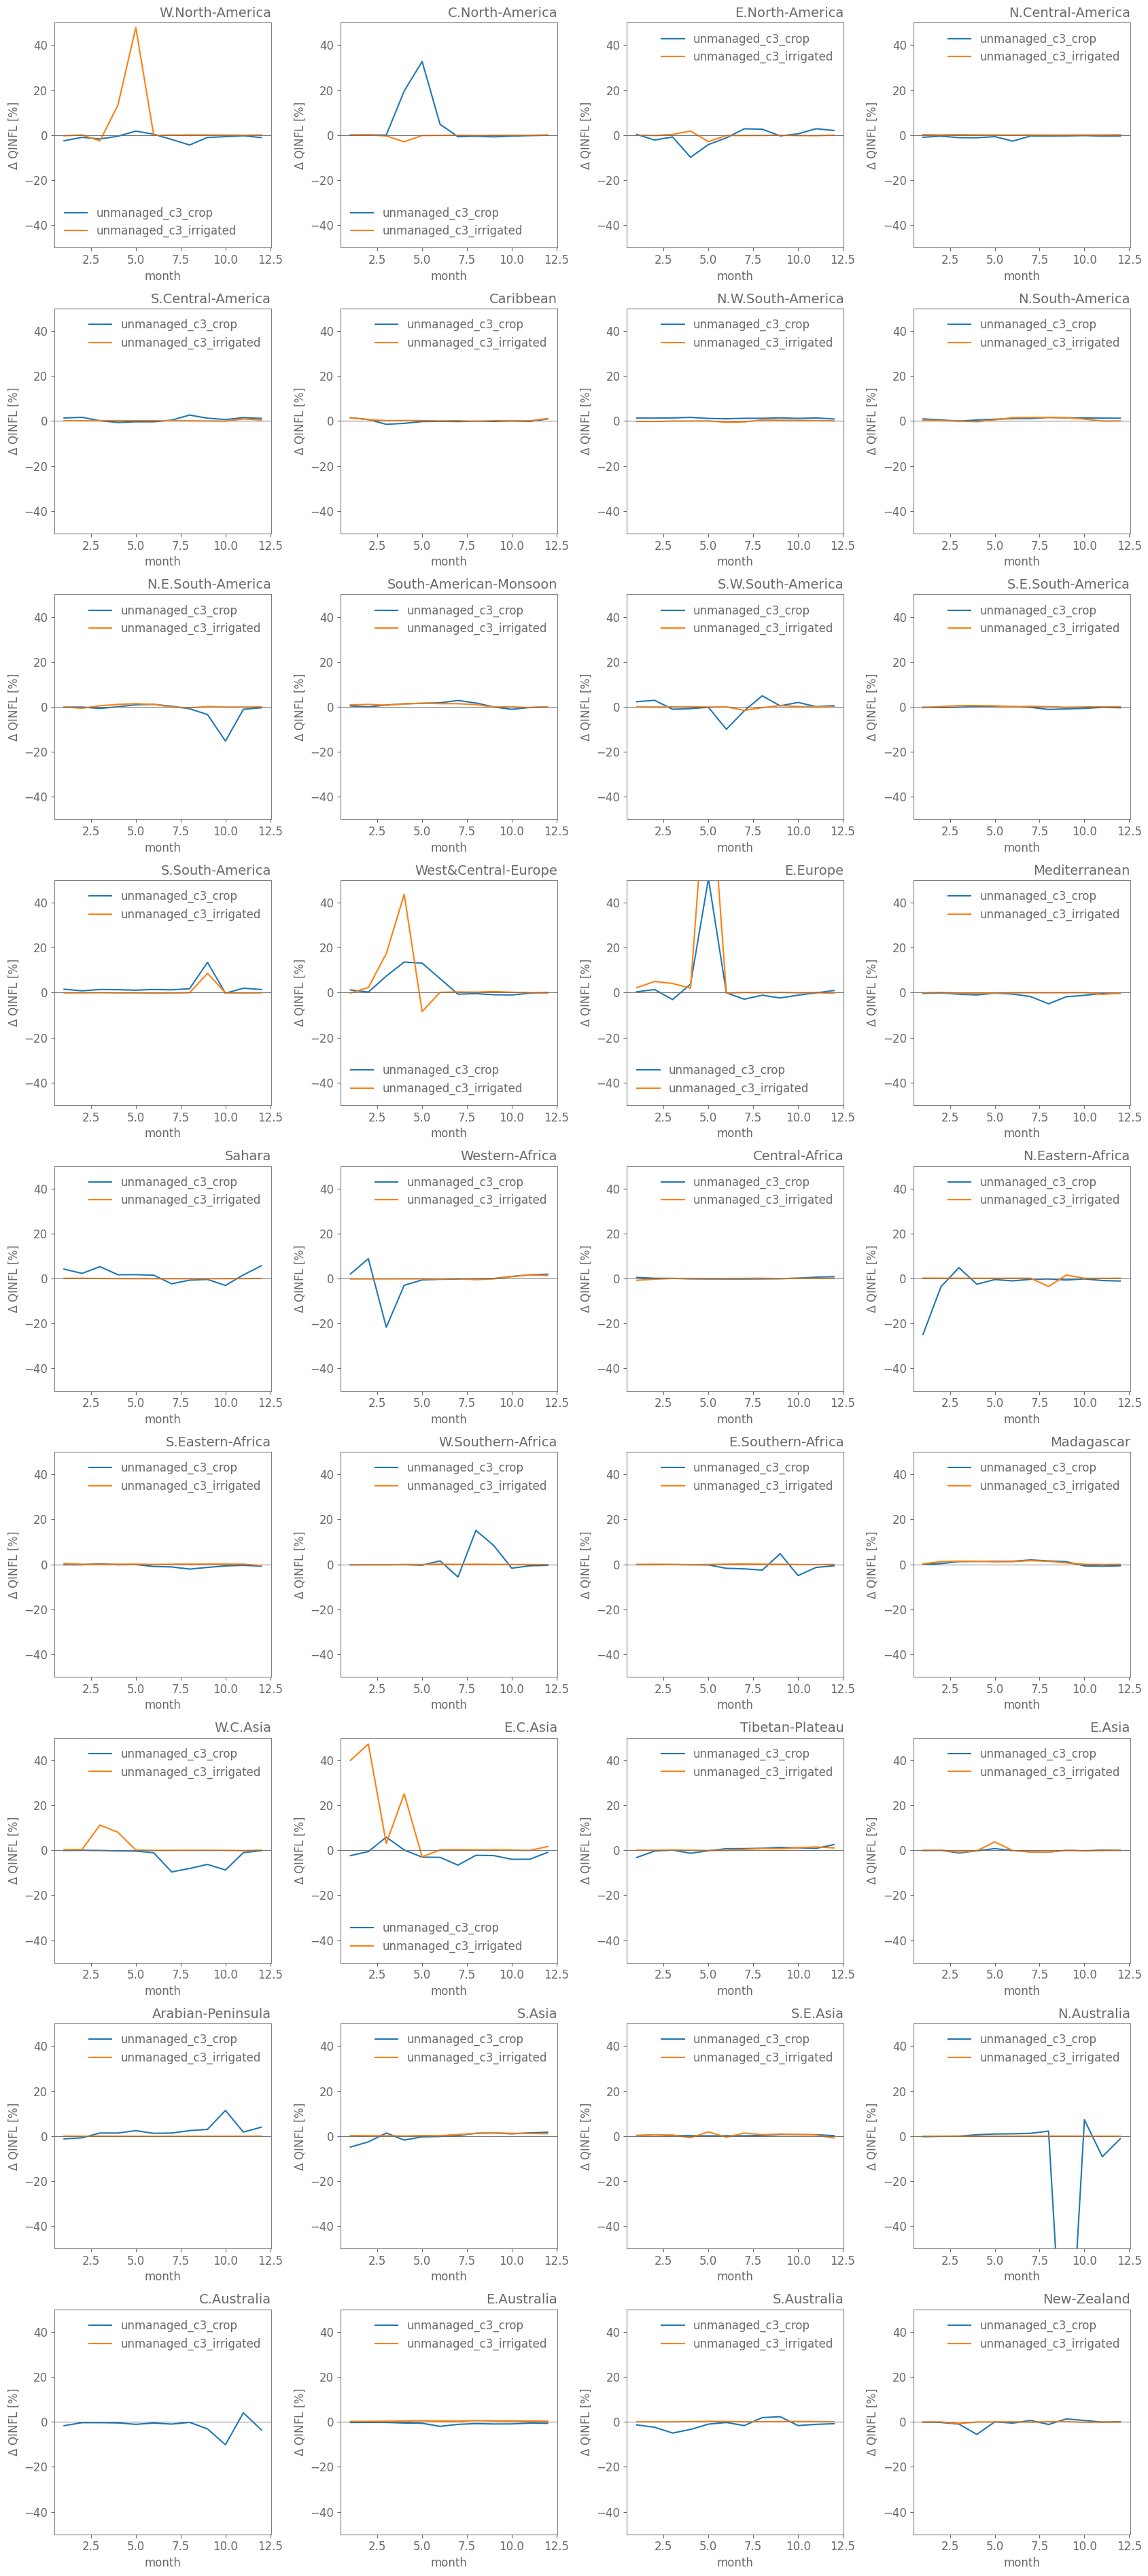

In [14]:
fig, axes = plt.subplots(9,4,figsize=figsize)
axes = axes.flatten()

for i,region in enumerate(region_ids):

    region_name = regionmask.defined_regions.ar6.land[region].name
    region_abbrev = regionmask.defined_regions.ar6.land[region].abbrev
    
    ax = axes[i]
    
    for pft_int in pft_list: 
        d_delta_rel_region[region].sel(pft=pft_int).plot(ax=ax, label=ivt_int2str(pft_int))
        ax.set_ylim([-50,50])
        ax.set_title(region_name, loc='right')
        ax.set_title('  ', loc='center')

        ax.legend(frameon=False)
        ax.axhline(y=0, color='dimgray', linewidth=0.5)
        ax.set_ylabel('$\Delta$ '+variable +' [%] ')
fig.tight_layout()